# ***P R O J E C T***
# **Digital Image Processing**

---


**Malaria detection classiication application Using Different CNN Models**

FA19-RCS-038

Muhammad Asif



---


---





The dataset is acquired from https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria which is publically available. It consists of 27,610 cell images classified into two groups; half of which in parasitized (infected) cells group and rest 50% in uninfected cells one. Equal data in both classes makes it a balanced dataset.

## Enabling and testing the GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

To constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.8463545820000036
GPU (s):
0.035255844000005254
GPU speedup over CPU: 80x


## **Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Imports**

Following are the libraries which are imported for further use in the project. However, some other libraries are also imported in proceeding cells as and when required.

In [4]:
import os
from os import listdir
from os.path import isdir
from pathlib import Path
import glob


import numpy as np  # linear algebra
from numpy import asarray  # data processing, CSV file I/O (e.g. pd.read_csv)
import csv

import time


import tensorflow
from keras import layers, models
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
import keras
import keras.backend as K

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from PIL import Image

import cv2
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import subplot, subplots, figure
%matplotlib inline
import seaborn as sns
import sklearn.metrics as metrics

from keras.preprocessing.image import img_to_array

# **Machine Learning Algorithms**
Following are some machine learning algorithms to be applied on the given dataset after some preprocessing

### **Load the Dataset**

URL to access data:  https://drive.google.com/drive/folders/1t9pwSM8DCjr_A6yaQp3QY6O15XxbA1jW?usp=sharing

In [5]:
dataset_path="/content/drive/MyDrive/malaria_cell_images/"

In [ ]:
# Following code generate a csv file named dataset.csv and code will be run two time to append both uninfected and parasitized folders images. the csv file generate 
# six columns, first column for label and rest 5 columns to extract feature in the form of contoures and hence all 27610 images will be converted into records having 
# 5 features and a label columns

label = 'Uninfected' # 
#label = 'Parasitized'  #one time
dirList = glob.glob(dataset_path + label + "/*.png")
#file = open("/content/drive/MyDrive/malaria_cell_csv/dataset.csv","a") # commented not to over write in existing file

for img_path in dirList:
  im = cv2.imread(img_path)
  im = cv2.GaussianBlur(im,(5,5),2)
  im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(im_gray,127,255,0)
  contours,_ = cv2.findContours(thresh,1,2)
  
  file.write(label)
  file.write(",")
  # for five features (countours) column for each
  for i in range(5):
    try:
      area = cv2.contourArea(contours[i])
      file.write(str(area))
    except:
      file.write("0")
    
    file.write(",")
  file.write("\n")

KeyboardInterrupt: ignored

### **Load Dataset in Pandas Dataframes**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
import joblib

## Load Dataset

dataframe = pd.read_csv("/content/drive/MyDrive/malaria_cell_csv/dataset.csv")
print(dataframe.head())

         Label  area_0   area_1   area_2   area_3   area_4
0  Parasitized   341.5    105.5    260.0  16515.0      0.0
1  Parasitized    96.0     55.5  15108.0      0.0      0.0
2  Parasitized     2.0      8.5     74.0    294.5  14453.0
3  Parasitized   190.0     16.0  12256.5      0.0      0.0
4  Parasitized   150.5  12270.0      0.0      0.0      0.0


### **Data Visualiation**

In [ ]:
dataframe.shape

(27610, 6)

### **Splitting Features and Labels**

In [ ]:
x = dataframe.drop(["Label"],axis=1)
y = dataframe["Label"]

### **Splitting data into train-test**

In [ ]:
# Split into training and test data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

### **Model building and training**

####**Random Forest Model**

In [ ]:
## Build a model (Random Forest)

RF_model = RandomForestClassifier(n_estimators=100,max_depth=5)
%time RF_model.fit(x_train,y_train)

joblib.dump(RF_model,"rf_malaria_100_5")

CPU times: user 957 ms, sys: 1.03 ms, total: 958 ms
Wall time: 958 ms


['rf_malaria_100_5']

In [ ]:
## Make predictions and get classification report

%time RF_predictions = RF_model.predict(x_test)

print(metrics.classification_report(RF_predictions,y_test))
print(RF_model.score(x_test,y_test))

CPU times: user 45.2 ms, sys: 0 ns, total: 45.2 ms
Wall time: 46.8 ms
              precision    recall  f1-score   support

 Parasitized       0.90      0.91      0.90      2761
  Uninfected       0.91      0.89      0.90      2761

    accuracy                           0.90      5522
   macro avg       0.90      0.90      0.90      5522
weighted avg       0.90      0.90      0.90      5522

0.9027526258601956


####**Adaptive Boost Classification (AdBoostClassifier) Model**

In [ ]:
Ada_model = AdaBoostClassifier(n_estimators=50, learning_rate=1)
%time Ada_model.fit(x_train,y_train)

joblib.dump(Ada_model,"Ada_malaria_100_1")

CPU times: user 1.48 s, sys: 11 ms, total: 1.49 s
Wall time: 1.49 s


['Ada_malaria_100_1']

In [ ]:
## Make predictions and get classification report

%time ada_predictions = Ada_model.predict(x_test)

print(metrics.classification_report(ada_predictions,y_test))
print(Ada_model.score(x_test,y_test))


CPU times: user 41.2 ms, sys: 0 ns, total: 41.2 ms
Wall time: 42.1 ms
              precision    recall  f1-score   support

 Parasitized       0.89      0.92      0.90      2714
  Uninfected       0.92      0.89      0.90      2808

    accuracy                           0.90      5522
   macro avg       0.90      0.90      0.90      5522
weighted avg       0.90      0.90      0.90      5522

0.9029337196667874


#### **Support Vector Classifier (SVC) Model**

In [ ]:
## Build a model (SVM)

from sklearn.svm import SVC # "Support vector classifier"
svm_model = SVC(kernel='rbf', C=50, gamma=0.005)
%time svm_model.fit(x_train,y_train)

CPU times: user 1min 23s, sys: 180 ms, total: 1min 23s
Wall time: 1min 23s


SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
## Make predictions and get classification report

%time svm_predictions = svm_model.predict(x_test)

print(metrics.classification_report(svm_predictions,y_test))
print(svm_model.score(x_test,y_test))

CPU times: user 1.84 s, sys: 976 µs, total: 1.84 s
Wall time: 1.85 s
              precision    recall  f1-score   support

 Parasitized       0.88      0.90      0.89      2746
  Uninfected       0.89      0.88      0.88      2776

    accuracy                           0.89      5522
   macro avg       0.89      0.89      0.89      5522
weighted avg       0.89      0.89      0.89      5522

0.8855487142339732


#### **Hyper parameter tuning (Support Vector Classifier)**

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=5, whiten=True, random_state=42)
svc = SVC(class_weight='balanced')
svm_model = make_pipeline(pca, svc)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svm_model, param_grid)

%time grid.fit(x_train,y_train)
print(grid.best_params_)

joblib.dump(svm_model,"svm_malaria_Lin_10")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Precomputed matrix must be a square matrix. Input is a 17670x5 matrix.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Precomputed matrix must be a square matrix. Input is a 17670x5 matrix.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Precomputed matrix must be a square matrix. Input is a 17670x5 matrix.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mo

CPU times: user 1h 32min 29s, sys: 45.5 s, total: 1h 33min 15s
Wall time: 1h 32min 33s
{'svc__C': 50, 'svc__gamma': 0.005, 'svc__kernel': 'rbf'}


['svm_malaria_Lin_10']

In [ ]:
svm_model = grid.best_estimator_

In [ ]:
## Make predictions and get classification report

svm_predictions = svm_model.predict(x_test)

print(metrics.classification_report(svm_predictions,y_test))
print(svm_model.score(x_test,y_test))

              precision    recall  f1-score   support

 Parasitized       0.90      0.91      0.90      2763
  Uninfected       0.91      0.89      0.90      2759

    accuracy                           0.90      5522
   macro avg       0.90      0.90      0.90      5522
weighted avg       0.90      0.90      0.90      5522

0.9009416877942774


# **Deep Learning Algorithms**

## **Load Dataset**

In [6]:
parasitized_images_path = '/content/drive/MyDrive/malaria_cell_images/Parasitized'
uninfected_images_path = '/content/drive/MyDrive/malaria_cell_images/Uninfected'

In [7]:
parasitized_data = os.listdir(parasitized_images_path)
print('Parasitized Images:=======',len(parasitized_data),parasitized_data[:10]) #the output we get are the .png files

uninfected_data = os.listdir(uninfected_images_path)
print('\n')
print('Uninfected Images:========',len(uninfected_data), uninfected_data[:10])

Parasitized Images:======= 13779 ['C92P53ThinF_IMG_20150821_151224_cell_211.png', 'C93P54ThinF_IMG_20150821_162901_cell_193.png', 'C92P53ThinF_IMG_20150821_151224_cell_209.png', 'C93P54ThinF_IMG_20150821_162901_cell_204.png', 'C93P54ThinF_IMG_20150821_163452_cell_205.png', 'C92P53ThinF_IMG_20150821_151224_cell_208.png', 'C93P54ThinF_IMG_20150821_162641_cell_226.png', 'C92P53ThinF_IMG_20150821_151646_cell_205.png', 'C93P54ThinF_IMG_20150821_162901_cell_198.png', 'C92P53ThinF_IMG_20150821_151646_cell_201.png']


Uninfected Images:======== 13831 ['C85P46ThinF_IMG_20150820_105154_cell_68.png', 'C85P46ThinF_IMG_20150820_105748_cell_217.png', 'C85P46ThinF_IMG_20150820_110143_cell_184.png', 'C85P46ThinF_IMG_20150820_110143_cell_159.png', 'C85P46ThinF_IMG_20150820_105748_cell_197.png', 'C85P46ThinF_IMG_20150820_110040_cell_100.png', 'C85P46ThinF_IMG_20150820_110040_cell_99.png', 'C85P46ThinF_IMG_20150820_110040_cell_222.png', 'C85P46ThinF_IMG_20150820_110040_cell_40.png', 'C85P46ThinF_IMG_2015

## **Visualize Data**

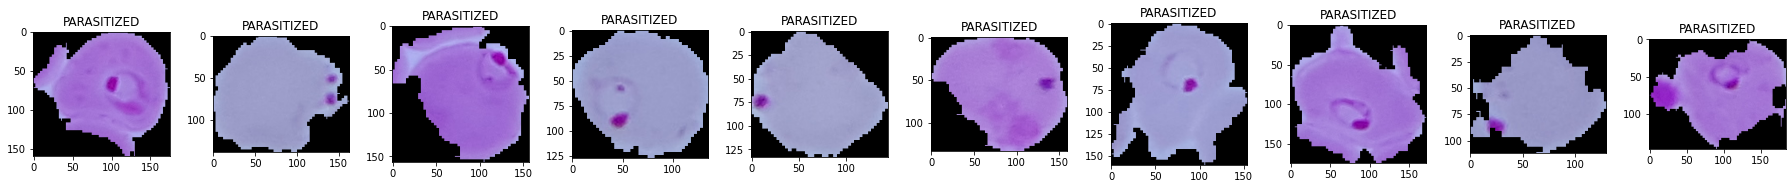

In [8]:
plt.figure(figsize = (25,25))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = cv2.imread(parasitized_images_path + "/" + parasitized_data[i])
    plt.imshow(img)
    plt.title('PARASITIZED')
    plt.tight_layout()
    plt.savefig('parasitized_images_Raw_sample.png')
plt.show()


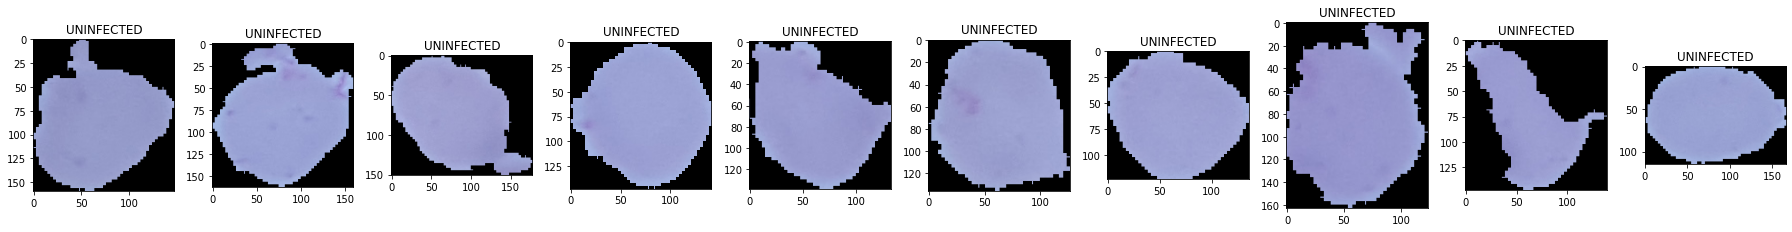

In [9]:
plt.figure(figsize = (25,25))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = cv2.imread(uninfected_images_path + "/" + uninfected_data[i])
    plt.imshow(img)
    plt.title('UNINFECTED')
    plt.tight_layout()
    plt.savefig('uninfected_images_Raw_sample.png')
plt.show()

## **Data Preprocessing and formulate data and labels**

In [ ]:
for img in uninfected_data:
    try:
        img_read = plt.imread("/content/drive/MyDrive/malaria_cell_images/Uninfected/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)    #  Label uninfected as 0
        count=count+1
        print(count)
        if count==1000:     # take 1000 images to shorten the dataset
          break
    except:
        None

In [10]:
# Combine all images in data array and their corresponding labels in label array 
# Resize the image as 50x50
# name parasitized images as binary 1 and uninfected images as binary 0
data = []
labels = []
count1=0
for img in parasitized_data:
    try:
        img_read = plt.imread("/content/drive/MyDrive/malaria_cell_images/Parasitized/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)    #  Label parasitized as 1
        count1=count1+1
        print(count1)
       # if count==1000:     # take 1000 images to shorten the dataset
       #   break
    except:
        None
count2=0
for img in uninfected_data:
    try:
        img_read = plt.imread("/content/drive/MyDrive/malaria_cell_images/Uninfected/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)    #  Label uninfected as 0
        count2=count2+1
        print(count2)
        if count2==count1:     # take 1000 images to shorten the dataset
          break
    except:
        None

Streaming output truncated to the last 5000 lines.
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969

In [11]:
# save numpy array datset as npy file
from numpy import asarray
from numpy import save
save('dataset_array.npy', data)

In [12]:
# load numpy array from npy file
from numpy import load
# load array
data1 = load('dataset_array.npy')

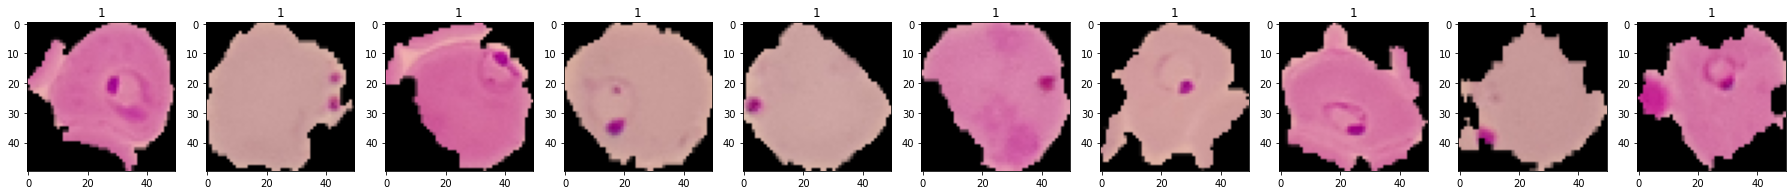

In [14]:
## Visualize images after preprocessing

plt.figure(figsize = (25,25))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title(labels[i])
    plt.imshow(data[i])
    plt.tight_layout()
plt.savefig('resized_merged_images_sample.png')
plt.show()

In [15]:
## convert image data to numpy arrays

image_data = np.array(data)
image_labels = np.array(labels)

In [16]:
image_data.shape

(27558, 50, 50, 3)

In [18]:
## Shuffle data so that both the classes may be mixed

idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
image_labels = image_labels[idx]

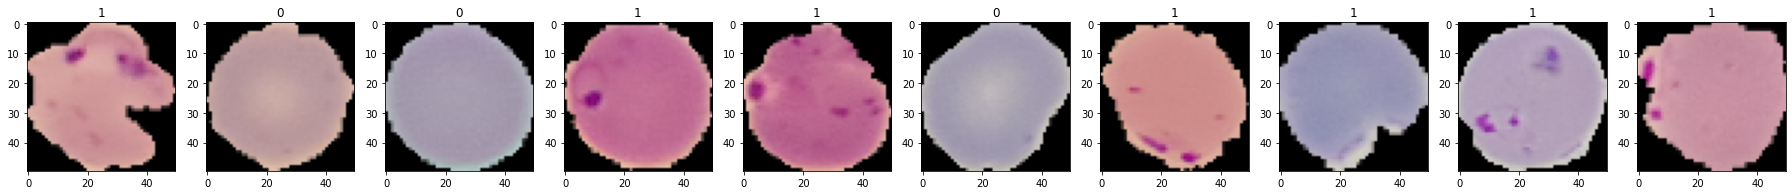

In [19]:
## Display images after shuffle

plt.figure(figsize = (25,25))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title(image_labels[i])
    plt.imshow(image_data[i])
    plt.tight_layout()
plt.savefig('preprocessed_images_sample.png')
plt.show()

In [20]:
## Splitting data into trainig and test set

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, image_labels, test_size = 0.2)

In [21]:
# Converts a class/ label vector (integers) to binary class matrix

y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

In [22]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF TESTING IMAGE DATA  : {x_test.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF TESTING LABELS  : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (22046, 50, 50, 3)
SHAPE OF TESTING IMAGE DATA  : (5512, 50, 50, 3)
SHAPE OF TRAINING LABELS : (22046, 2)
SHAPE OF TESTING LABELS  : (5512, 2)


## **Model Building**

In [23]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

In [24]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [25]:
#Model instantiateion
height = 50
width = 50
classes = 2
channels = 3
model = CNNbuild(height = height, width = width, classes = classes, channels = channels)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 32)        1

In [26]:
#compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [28]:
import time
model_tt0 = time.time()
model_history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))
model_tt1 = time.time()
model_time_linear_train = model_tt1 - model_tt0

Epoch 1/20
689/689 [==============================] - 5s 6ms/step - loss: 0.8140 - accuracy: 0.6686 - val_loss: 1.4761 - val_accuracy: 0.6544
Epoch 2/20
689/689 [==============================] - 4s 5ms/step - loss: 0.2581 - accuracy: 0.9016 - val_loss: 0.2849 - val_accuracy: 0.9127
Epoch 3/20
689/689 [==============================] - 4s 5ms/step - loss: 0.1863 - accuracy: 0.9315 - val_loss: 0.1490 - val_accuracy: 0.9536
Epoch 4/20
689/689 [==============================] - 4s 5ms/step - loss: 0.1699 - accuracy: 0.9421 - val_loss: 0.2196 - val_accuracy: 0.9332
Epoch 5/20
689/689 [==============================] - 4s 5ms/step - loss: 0.1670 - accuracy: 0.9449 - val_loss: 0.2141 - val_accuracy: 0.9269
Epoch 6/20
689/689 [==============================] - 4s 5ms/step - loss: 0.1609 - accuracy: 0.9461 - val_loss: 0.1676 - val_accuracy: 0.9516
Epoch 7/20
689/689 [==============================] - 4s 5ms/step - loss: 0.1565 - accuracy: 0.9480 - val_loss: 0.1560 - val_accuracy: 0.9505
Epoch 

NameError: ignored

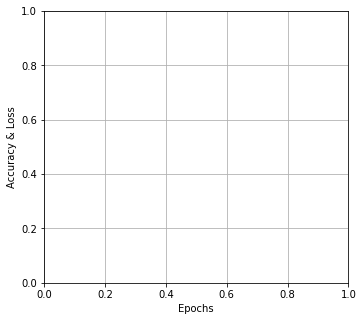

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(model_history.history['accuracy'], color='blue', label='train')
plt.plot(model_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(model_history.history['val_accuracy'], color='green', label='test')
plt.plot(model_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('model_acc_plot.png')
plt.show()

Accuracy: 0.818
Matthews CC: 0.683
F1 Score: 0.779
Recall: 0.639
Sensitivity: 0.639
Specificity: 1.000
Training time: 6.392259s; Prediction time: 0.056542s
Classification Report: 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       198
           1       0.00      0.00      0.00       202

    accuracy                           0.49       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.49      0.33       400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


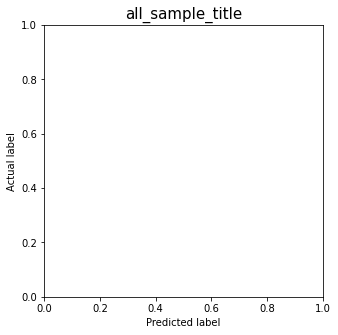

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np
model_pt1 = time.time()
model_y_pred = model.predict(x_test)
model_pt2 = time.time()
model_time_linear_predict = model_pt2 - model_pt1

y_test_no_hot=np.argmax(y_test, axis=1)
model_y_pred = np.argmax(model_y_pred, axis=1)

c_matrix = confusion_matrix(y_test_no_hot, model_y_pred, labels=[0,1])
TP, FP, FN, TN = c_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
#sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test_no_hot, model_y_pred))
plt.title('all_sample_title', size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test_no_hot, model_y_pred)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test_no_hot, model_y_pred)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test_no_hot, model_y_pred)))
print('Recall: {0:.3f}'.format(metrics.recall_score(y_test_no_hot, model_y_pred)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test_no_hot, model_y_pred)))
print('Specificity: {0:.3f}'.format(specificity))
print("Training time: %fs; Prediction time: %fs" % (model_time_linear_train, model_time_linear_predict))
y_pred_classes = [np.argmax(element) for element in model_y_pred]
print("Classification Report: \n", classification_report(y_test_no_hot, y_pred_classes))

In [ ]:
model_accuracy_score=round(accuracy_score(y_test_no_hot, model_y_pred)*100,1)
model_f1_score = round(f1_score(y_test_no_hot, model_y_pred, average='weighted')*100,1)
model_average_precision_score =round(average_precision_score(y_test_no_hot, model_y_pred)*100,1)
model_recall_score = round(recall_score(y_test_no_hot, model_y_pred, average='macro')*100,1)
print('Model Accuracy Score:  ', model_accuracy_score)
print('Model F1 Score:        ', model_f1_score)
print('Model Precision Score: ', model_average_precision_score)
print('Model Recall Score:    ', model_recall_score)

Model Accuracy Score:   60.2
Model F1 Score:         57.8
Model Precision Score:  57.9
Model Recall Score:     60.5


##**Data Augmentation for Improving Accuracy**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = False)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [ ]:
#calling the same model as above
model_aug = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [ ]:
#compile the model
optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model_aug.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [ ]:
#fit the model on the augmented dataset

import time
model_aug_tt0 = time.time()
history_aug = model_aug.fit_generator(train_generator, steps_per_epoch = len(x_train) // 64, epochs = 20, validation_data=val_generator)
model_aug_tt1 = time.time()
model_aug_time_linear_train = model_aug_tt1 - model_aug_tt0

Epoch 1/20
 1/25 [>.............................] - ETA: 1s - loss: 0.2270 - accuracy: 0.9219

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


25/25 [==============================] - 1s 52ms/step - loss: 0.2753 - accuracy: 0.8913 - val_loss: 0.2230 - val_accuracy: 0.9100
Epoch 2/20
25/25 [==============================] - 1s 52ms/step - loss: 0.2469 - accuracy: 0.9081 - val_loss: 2.4964 - val_accuracy: 0.5500
Epoch 3/20
25/25 [==============================] - 1s 53ms/step - loss: 0.2481 - accuracy: 0.9087 - val_loss: 0.2133 - val_accuracy: 0.9300
Epoch 4/20
25/25 [==============================] - 1s 54ms/step - loss: 0.2509 - accuracy: 0.9062 - val_loss: 4.9289 - val_accuracy: 0.5050
Epoch 5/20
25/25 [==============================] - 1s 53ms/step - loss: 0.2556 - accuracy: 0.9006 - val_loss: 2.1400 - val_accuracy: 0.5025
Epoch 6/20
25/25 [==============================] - 1s 55ms/step - loss: 0.2567 - accuracy: 0.9025 - val_loss: 1.3595 - val_accuracy: 0.5625
Epoch 7/20
25/25 [==============================] - 1s 55ms/step - loss: 0.2485 - accuracy: 0.9075 - val_loss: 1.2465 - val_accuracy: 0.5000
Epoch 8/20
25/25 [======

In [ ]:
#evaluate the model on augmented test data
predict_aug = model_aug.evaluate_generator(val_generator, steps = 5)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


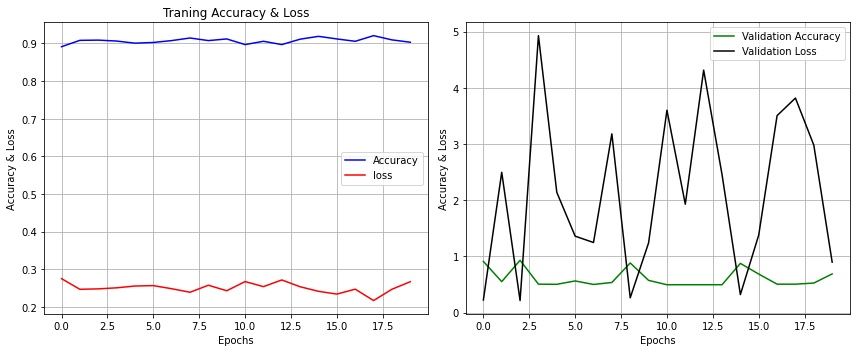

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(history_aug.history['accuracy'], color='blue', label='train')
plt.plot(history_aug.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(history_aug.history['val_accuracy'], color='green', label='test')
plt.plot(history_aug.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('model_aug_acc_plot.png')
plt.show()

Accuracy: 0.505
Matthews CC: 0.000
F1 Score: 0.671
Recall: 1.000
Sensitivity: 1.000
Specificity: 0.505
Training time: 26.966399s; Prediction time: 0.065529s
Classification Report: 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       198
           1       0.00      0.00      0.00       202

    accuracy                           0.49       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.49      0.33       400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


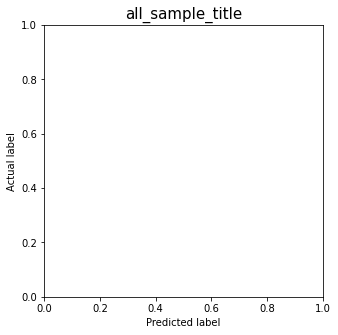

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np
model_aug_pt1 = time.time()
model_aug_y_pred = model_aug.predict(x_test)
model_aug_pt2 = time.time()
model_aug_time_linear_predict = model_aug_pt2 - model_aug_pt1

y_test_no_hot=np.argmax(y_test, axis=1)
model_aug_y_pred = np.argmax(model_aug_y_pred, axis=1)

c_matrix = confusion_matrix(y_test_no_hot, model_aug_y_pred, labels=[0,1])
TP, FP, FN, TN = c_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
#sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test_no_hot, model_aug_y_pred))
plt.title('all_sample_title', size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test_no_hot, model_aug_y_pred)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test_no_hot, model_aug_y_pred)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test_no_hot, model_aug_y_pred)))
print('Recall: {0:.3f}'.format(metrics.recall_score(y_test_no_hot, model_aug_y_pred)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test_no_hot, model_aug_y_pred)))
print('Specificity: {0:.3f}'.format(specificity))
print("Training time: %fs; Prediction time: %fs" % (model_aug_time_linear_train, model_aug_time_linear_predict))
y_pred_classes = [np.argmax(element) for element in model_y_pred]
print("Classification Report: \n", classification_report(y_test_no_hot, y_pred_classes))

In [ ]:
model_aug_accuracy_score=round(accuracy_score(y_test_no_hot, model_aug_y_pred)*100,1)
model_aug_f1_score = round(f1_score(y_test_no_hot, model_aug_y_pred, average='weighted')*100,1)
model_aug_average_precision_score =round(average_precision_score(y_test_no_hot, model_aug_y_pred)*100,1)
model_aug_recall_score = round(recall_score(y_test_no_hot, model_aug_y_pred, average='macro')*100,1)
print('Model Accuracy Score:  ', model_accuracy_score)
print('Model F1 Score:        ', model_f1_score)
print('Model Precision Score: ', model_average_precision_score)
print('Model Recall Score:    ', model_recall_score)

Model Accuracy Score:   60.2
Model F1 Score:         57.8
Model Precision Score:  57.9
Model Recall Score:     60.5


### **ANN (Artificial Neural Network) Model**

In [ ]:
ann_model = models.Sequential([
        layers.Flatten(input_shape=x_train[0].shape),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(classes, activation='sigmoid')    
    ])

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        ann_model.summary()

ann_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3000)              22503000  
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 2002      
Total params: 25,506,002
Trainable params: 25,506,002
Non-trainable params: 0
_________________________________________________________________


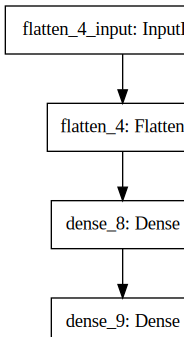

In [ ]:
SVG(model_to_dot(ann_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % ann_model.inputs)
print('Outputs: %s' % ann_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'flatten_4_input')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_10')>]


####**Compile & Apply Model**

In [ ]:
ann_model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time
ann_model_tt0 = time.time()
ann_model_history = ann_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))
ann_model_tt1 = time.time()
ann_model_time_linear_train = ann_model_tt1-ann_model_tt0

Epoch 1/20
50/50 [==============================] - 0s 7ms/step - loss: 0.1571 - accuracy: 0.9319 - val_loss: 1.9638 - val_accuracy: 0.6250
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.1975 - accuracy: 0.9206 - val_loss: 1.6708 - val_accuracy: 0.6000
Epoch 3/20
50/50 [==============================] - 0s 6ms/step - loss: 0.1025 - accuracy: 0.9619 - val_loss: 2.0141 - val_accuracy: 0.6100
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0490 - accuracy: 0.9856 - val_loss: 2.1462 - val_accuracy: 0.6325
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0790 - accuracy: 0.9681 - val_loss: 2.0764 - val_accuracy: 0.6175
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.3165 - accuracy: 0.8906 - val_loss: 1.4359 - val_accuracy: 0.6125
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0787 - accuracy: 0.9762 - val_loss: 1.6465 - val_accuracy: 0.6200
Epoch 8/20
50/50 [==

#### **Performance Visualization**

In [ ]:
# Validation Score
ann_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 2.1935 - accuracy: 0.6350


[2.193495512008667, 0.6349999904632568]

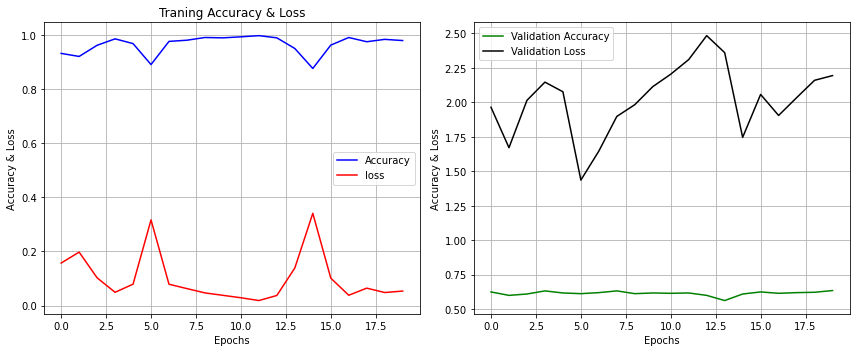

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(ann_model_history.history['accuracy'], color='blue', label='train')
plt.plot(ann_model_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(ann_model_history.history['val_accuracy'], color='green', label='test')
plt.plot(ann_model_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('ann_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

ann_model_pt1 = time.time()
ann_model_y_pred = ann_model.predict(x_test)
ann_model_pt2 = time.time()
ann_model_time_linear_predict = ann_model_pt2-ann_model_pt1
ann_y_pred_classes = [np.argmax(element) for element in ann_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (ann_model_time_linear_train, ann_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, ann_y_pred_classes))

Training time: 5.834383s; Prediction time: 0.060782s
Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.61      0.62       198
           1       0.63      0.66      0.65       202

    accuracy                           0.64       400
   macro avg       0.64      0.63      0.63       400
weighted avg       0.64      0.64      0.63       400



In [ ]:
ann_model_accuracy_score=round(accuracy_score(y_test_rounded, ann_y_pred_classes)*100,1)
ann_model_f1_score = round(f1_score(y_test_rounded, ann_y_pred_classes, average='weighted')*100,1)
ann_model_average_precision_score =round(average_precision_score(y_test_rounded, ann_y_pred_classes)*100,1)
ann_model_recall_score = round(recall_score(y_test_rounded, ann_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', ann_model_accuracy_score)
print('Model F1 Score:        ', ann_model_f1_score)
print('Model Precision Score: ', ann_model_average_precision_score)
print('Model Recall Score:    ', ann_model_recall_score)

Model Accuracy Score:   63.5
Model F1 Score:         63.5
Model Precision Score:  58.9
Model Recall Score:     63.5


###**CNN (Convolutional Neural Network) Model**

In [ ]:
cnn_model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=x_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(classes, activation='softmax')
])

In [ ]:
cnn_model1 = models.Sequential([
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=x_train[0].shape),
    layers.Dropout(0.2),
    layers.Conv2D(filters=32, kernel_size=(4, 4), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=256, kernel_size=(2, 2), activation='relu'),
    layers.Dropout(0.2),
    layers.AveragePooling2D((3,3)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(classes, activation='softmax')
])

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout
with open('cnn_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        cnn_model.summary()
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                495680    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                

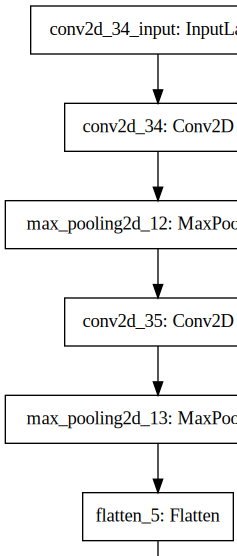

In [ ]:
SVG(model_to_dot(cnn_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % cnn_model.inputs)
print('Outputs: %s' % cnn_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'conv2d_34_input')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_12')>]


####**Compile & Apply Model**

In [ ]:
cnn_model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time
cnn_model_tt0 = time.time()
cnn_model_history = cnn_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))
cnn_model_tt1 = time.time()
cnn_model_time_linear_train = cnn_model_tt1 - cnn_model_tt0

Epoch 1/20
50/50 [==============================] - 1s 8ms/step - loss: 0.7186 - accuracy: 0.4963 - val_loss: 0.6924 - val_accuracy: 0.4950
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6854 - val_accuracy: 0.6075
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.6788 - accuracy: 0.5715 - val_loss: 0.6866 - val_accuracy: 0.5425
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.6289 - accuracy: 0.6373 - val_loss: 0.6313 - val_accuracy: 0.6525
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 0.5734 - accuracy: 0.7442 - val_loss: 0.5968 - val_accuracy: 0.6800
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.5108 - accuracy: 0.7568 - val_loss: 0.7527 - val_accuracy: 0.6025
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.4887 - accuracy: 0.7525 - val_loss: 0.6312 - val_accuracy: 0.6775
Epoch 8/20
50/50 [==

#### **Performance Visualization**

In [ ]:
# Validation Score
cnn_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.7451 - accuracy: 0.7975


[0.7451175451278687, 0.7975000143051147]

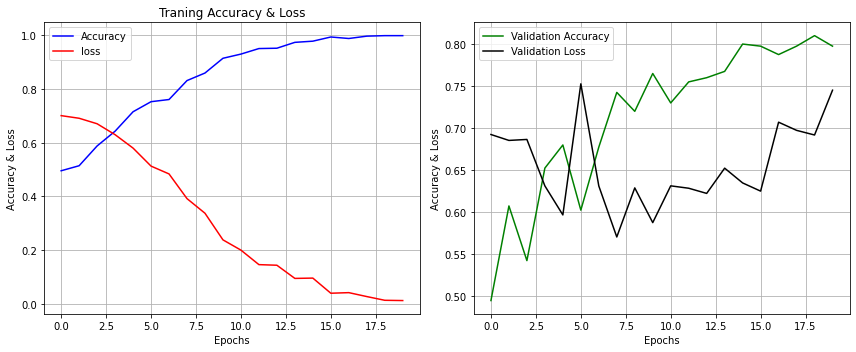

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(cnn_model_history.history['accuracy'], color='blue', label='train')
plt.plot(cnn_model_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(cnn_model_history.history['val_accuracy'], color='green', label='test')
plt.plot(cnn_model_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('cnn_model_acc_plot.png')
plt.show()

#### **Training/ Prediction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

cnn_model_pt1 = time.time()
cnn_model_y_pred = cnn_model.predict(x_test)
cnn_model_pt2 = time.time()
cnn_model_time_linear_predict = cnn_model_pt2-cnn_model_pt1
cnn_y_pred_classes = [np.argmax(element) for element in cnn_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (cnn_model_time_linear_train, cnn_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, cnn_y_pred_classes))

Training time: 5.750149s; Prediction time: 0.052906s
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79       198
           1       0.80      0.81      0.80       202

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



In [ ]:
cnn_model_accuracy_score=round(accuracy_score(y_test_rounded, cnn_y_pred_classes)*100,1)
cnn_model_f1_score = round(f1_score(y_test_rounded, cnn_y_pred_classes, average='weighted')*100,1)
cnn_model_average_precision_score =round(average_precision_score(y_test_rounded, cnn_y_pred_classes)*100,1)
cnn_model_recall_score = round(recall_score(y_test_rounded, cnn_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', cnn_model_accuracy_score)
print('Model F1 Score:        ', cnn_model_f1_score)
print('Model Precision Score: ', cnn_model_average_precision_score)
print('Model Recall Score:    ', cnn_model_recall_score)

Model Accuracy Score:   79.8
Model F1 Score:         79.7
Model Precision Score:  73.9
Model Recall Score:     79.7


### **Alexnet Model**

In [ ]:
alexnet_model = Sequential()

# first conv-pool block: 
alexnet_model.add(Conv2D(96, kernel_size=(11, 11), strides=(1, 1), activation='relu', input_shape=x_train[0].shape))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
alexnet_model.add(BatchNormalization())

# second conv-pool block: 
alexnet_model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
alexnet_model.add(BatchNormalization())

# third conv-pool block: 
alexnet_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
alexnet_model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
alexnet_model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
alexnet_model.add(BatchNormalization())

# dense layers: 
alexnet_model.add(Flatten())
alexnet_model.add(Dense(4096, activation='tanh'))
alexnet_model.add(Dropout(0.5))
alexnet_model.add(Dense(4096, activation='tanh'))
alexnet_model.add(Dropout(0.5))

# output layer: 
alexnet_model.add(Dense(classes, activation='softmax'))

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('alexnet_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        alexnet_model.summary()

alexnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 40, 40, 96)        34944     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 38, 38, 96)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 38, 38, 96)        384       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 256)       614656    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 30, 30, 256)      

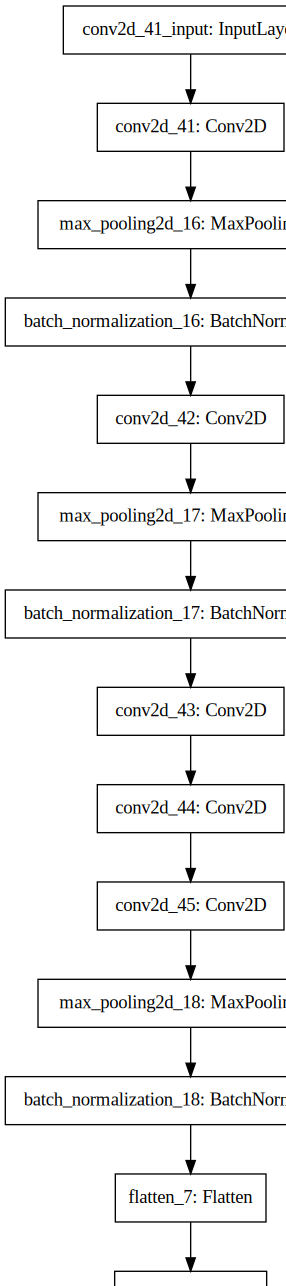

In [ ]:
SVG(model_to_dot(alexnet_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % alexnet_model.inputs)
print('Outputs: %s' % alexnet_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'conv2d_41_input')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_19')>]


####**Compile & Apply Model**

In [ ]:
alexnet_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
import time
alexnet_model_tt0 = time.time()
alexnet_model_history = alexnet_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))
alexnet_model_tt1 = time.time()
alexnet_model_time_linear_train = alexnet_model_tt1-alexnet_model_tt0

Epoch 1/20
50/50 [==============================] - 5s 94ms/step - loss: 1.1166 - accuracy: 0.6550 - val_loss: 3.7308 - val_accuracy: 0.4950
Epoch 2/20
50/50 [==============================] - 5s 94ms/step - loss: 0.8564 - accuracy: 0.6850 - val_loss: 1.0609 - val_accuracy: 0.4850
Epoch 3/20
50/50 [==============================] - 5s 94ms/step - loss: 0.6689 - accuracy: 0.7306 - val_loss: 1.4517 - val_accuracy: 0.4875
Epoch 4/20
50/50 [==============================] - 5s 94ms/step - loss: 0.5151 - accuracy: 0.7925 - val_loss: 2.1313 - val_accuracy: 0.4950
Epoch 5/20
50/50 [==============================] - 5s 94ms/step - loss: 0.5626 - accuracy: 0.7862 - val_loss: 1.9652 - val_accuracy: 0.4950
Epoch 6/20
50/50 [==============================] - 5s 94ms/step - loss: 0.5456 - accuracy: 0.7881 - val_loss: 2.6999 - val_accuracy: 0.4950
Epoch 7/20
50/50 [==============================] - 5s 94ms/step - loss: 0.5543 - accuracy: 0.7731 - val_loss: 2.3419 - val_accuracy: 0.4950
Epoch 8/20
50

#### **Performance Visualization**

In [ ]:
# Validation Score
alexnet_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 27ms/step - loss: 4.0254 - accuracy: 0.5100


[4.025407791137695, 0.5099999904632568]

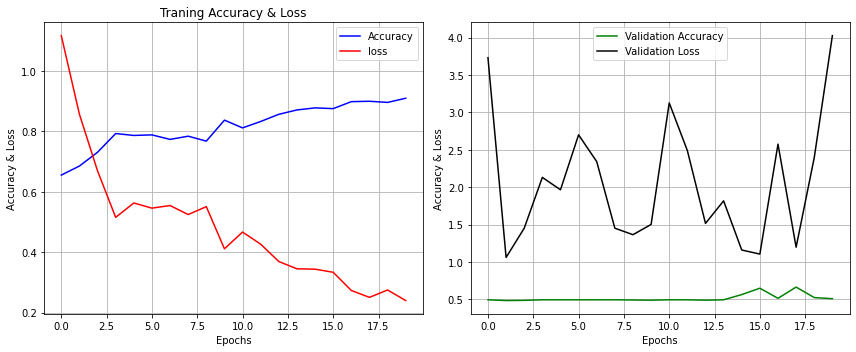

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(alexnet_model_history.history['accuracy'], color='blue', label='train')
plt.plot(alexnet_model_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(alexnet_model_history.history['val_accuracy'], color='green', label='test')
plt.plot(alexnet_model_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('alexnet_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

alexnet_model_pt1 = time.time()
alexnet_model_y_pred = alexnet_model.predict(x_test)
alexnet_model_pt2 = time.time()
alexnet_model_time_linear_predict = alexnet_model_pt2-alexnet_model_pt1
alexnet_y_pred_classes = [np.argmax(element) for element in alexnet_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (alexnet_model_time_linear_train, alexnet_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, alexnet_y_pred_classes))

Training time: 94.022292s; Prediction time: 0.405466s
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.01      0.02       198
           1       0.51      1.00      0.67       202

    accuracy                           0.51       400
   macro avg       0.75      0.51      0.35       400
weighted avg       0.75      0.51      0.35       400



In [ ]:
alexnet_model_accuracy_score=round(accuracy_score(y_test_rounded, alexnet_y_pred_classes)*100,1)
alexnet_model_f1_score = round(f1_score(y_test_rounded, alexnet_y_pred_classes, average='weighted')*100,1)
alexnet_model_average_precision_score =round(average_precision_score(y_test_rounded, alexnet_y_pred_classes)*100,1)
alexnet_model_recall_score = round(recall_score(y_test_rounded, alexnet_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', alexnet_model_accuracy_score)
print('Model F1 Score:        ', alexnet_model_f1_score)
print('Model Precision Score: ', alexnet_model_average_precision_score)
print('Model Recall Score:    ', alexnet_model_recall_score)

Model Accuracy Score:   51.0
Model F1 Score:         35.0
Model Precision Score:  50.8
Model Recall Score:     50.5


### **LeNet-5 Model**

In [ ]:
lenet_5_model = keras.models.Sequential([
    
    # first conv-pool block:
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=x_train[0].shape, padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    
    # second conv-pool block:
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    
    # dense layers:
    keras.layers.Flatten(), #Flatten
    keras.layers.Dense(120, activation='tanh'), #C5
    keras.layers.Dense(84, activation='tanh'), #F6
    
    # output layer:
    keras.layers.Dense(classes, activation='softmax') #Output layer
])

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('lenet_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        lenet_5_model.summary()

lenet_5_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 50, 50, 6)         456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 25, 25, 6)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 21, 21, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 120)               192120    
_________________________________________________________________
dense_21 (Dense)             (None, 84)               

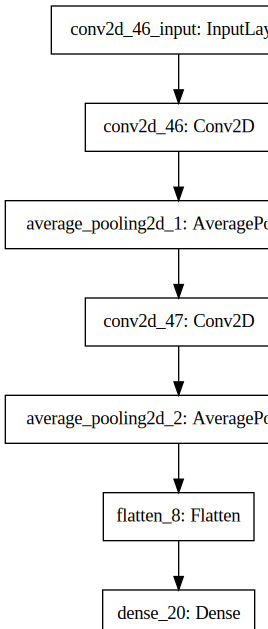

In [ ]:
SVG(model_to_dot(lenet_5_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % lenet_5_model.inputs)
print('Outputs: %s' % lenet_5_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'conv2d_50_input')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_29')>]


####**Compile & Apply Model**

In [ ]:
lenet_5_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import time
Le_t0 = time.time()
Le_history = lenet_5_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))
Le_t1 = time.time()
Le_time_linear_train = Le_t1 - Le_t0

Epoch 1/20
50/50 [==============================] - 0s 5ms/step - loss: 0.4137 - accuracy: 0.8100 - val_loss: 0.6613 - val_accuracy: 0.6825
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3986 - accuracy: 0.8100 - val_loss: 0.7148 - val_accuracy: 0.6875
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3627 - accuracy: 0.8406 - val_loss: 0.6899 - val_accuracy: 0.7000
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3383 - accuracy: 0.8519 - val_loss: 0.6781 - val_accuracy: 0.7025
Epoch 5/20
50/50 [==============================] - 0s 4ms/step - loss: 0.3355 - accuracy: 0.8594 - val_loss: 0.7220 - val_accuracy: 0.6850
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2983 - accuracy: 0.8725 - val_loss: 0.6805 - val_accuracy: 0.6900
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2677 - accuracy: 0.8950 - val_loss: 0.7307 - val_accuracy: 0.7100
Epoch 8/20
50/50 [==

#### **Performance Visualization**

In [ ]:
# Validation Accuracy
lenet_5_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.9677 - accuracy: 0.7175


[0.967650294303894, 0.7174999713897705]

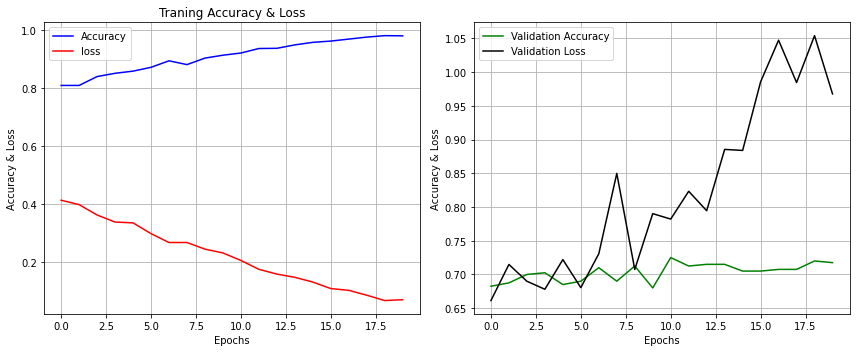

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Le_history.history['accuracy'], color='blue', label='train')
plt.plot(Le_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Le_history.history['val_accuracy'], color='green', label='test')
plt.plot(Le_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('Le_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

Le_model_pt1 = time.time()
Le_model_y_pred = lenet_5_model.predict(x_test)
Le_model_pt2 = time.time()
Le_model_time_linear_predict = Le_model_pt2-Le_model_pt1
Le_y_pred_classes = [np.argmax(element) for element in Le_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (Le_time_linear_train, Le_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, Le_y_pred_classes))

Training time: 4.751744s; Prediction time: 0.056775s
Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.77      0.73       198
           1       0.75      0.67      0.70       202

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



In [ ]:
lenet_model_accuracy_score=round(accuracy_score(y_test_rounded, Le_y_pred_classes)*100,1)
lenet_model_f1_score = round(f1_score(y_test_rounded, Le_y_pred_classes, average='weighted')*100,1)
lenet_model_average_precision_score =round(average_precision_score(y_test_rounded, Le_y_pred_classes)*100,1)
lenet_model_recall_score = round(recall_score(y_test_rounded, Le_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', lenet_model_accuracy_score)
print('Model F1 Score:        ', lenet_model_f1_score)
print('Model Precision Score: ', lenet_model_average_precision_score)
print('Model Recall Score:    ', lenet_model_recall_score)

Model Accuracy Score:   71.8
Model F1 Score:         71.7
Model Precision Score:  66.6
Model Recall Score:     71.8


### **DenseNet Model**

In [ ]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
denseNet_model = densenet(x_train[0].shape, classes)

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('denset_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        denseNet_model.summary()


denseNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 25, 25, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 13, 13, 64)   0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 13, 13, 64)   256         max_pooling2d_20[0][0]           
______________________________________________________________________________________________

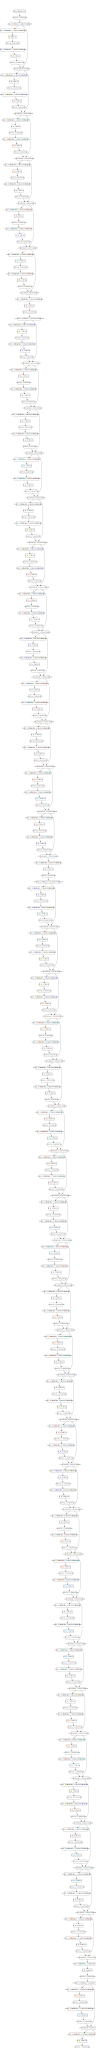

In [ ]:
SVG(model_to_dot(denseNet_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % denseNet_model.inputs)
print('Outputs: %s' % denseNet_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_23')>]


####**Compile & Apply Model**

In [ ]:
denseNet_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
import time
De_t0 = time.time()
De_history = denseNet_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))
De_t1 = time.time()
De_time_linear_train = De_t1-De_t0

Epoch 1/20
50/50 [==============================] - 2s 46ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.4676 - val_accuracy: 0.8350
Epoch 2/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0122 - accuracy: 0.9975 - val_loss: 0.4317 - val_accuracy: 0.8575
Epoch 3/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0108 - accuracy: 0.9981 - val_loss: 0.2968 - val_accuracy: 0.9100
Epoch 4/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0081 - accuracy: 0.9987 - val_loss: 3.0246 - val_accuracy: 0.5425
Epoch 5/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0365 - accuracy: 0.9887 - val_loss: 0.9691 - val_accuracy: 0.7575
Epoch 6/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 4.9655 - val_accuracy: 0.5250
Epoch 7/20
50/50 [==============================] - 2s 45ms/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.6824 - val_accuracy: 0.8600
Epoch 8/20
50

#### **Performance Visualization**

In [ ]:
# Validation Accuracy
denseNet_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 16ms/step - loss: 3.1340 - accuracy: 0.6125


[3.133998394012451, 0.612500011920929]

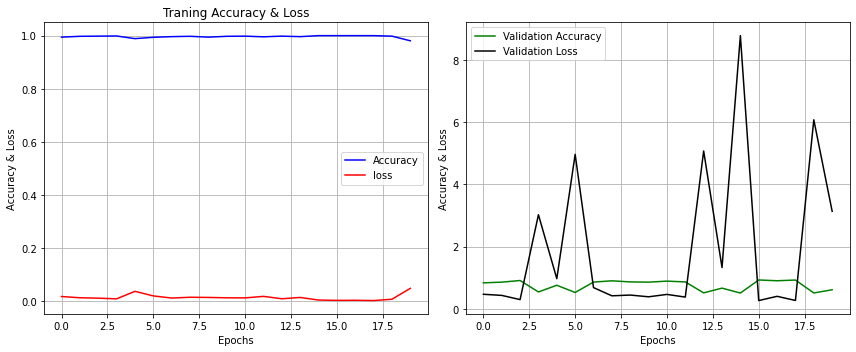

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(De_history.history['accuracy'], color='blue', label='train')
plt.plot(De_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(De_history.history['val_accuracy'], color='green', label='test')
plt.plot(De_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('De_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

De_model_pt1 = time.time()
De_model_y_pred = denseNet_model.predict(x_test)
De_model_pt2 = time.time()
De_model_time_linear_predict = cnn_model_pt2-cnn_model_pt1
De_y_pred_classes = [np.argmax(element) for element in De_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (De_time_linear_train, De_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, y_pred_classes))

Training time: 45.295238s; Prediction time: 0.052253s
Classification Report: 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       198
           1       0.00      0.00      0.00       202

    accuracy                           0.49       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.49      0.33       400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Denet_model_accuracy_score=round(accuracy_score(y_test_rounded, De_y_pred_classes)*100,1)
Denet_model_f1_score = round(f1_score(y_test_rounded, De_y_pred_classes, average='weighted')*100,1)
Denet_model_average_precision_score =round(average_precision_score(y_test_rounded, De_y_pred_classes)*100,1)
Denet_model_recall_score = round(recall_score(y_test_rounded, De_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', Denet_model_accuracy_score)
print('Model F1 Score:        ', Denet_model_f1_score)
print('Model Precision Score: ', Denet_model_average_precision_score)
print('Model Recall Score:    ', Denet_model_recall_score)

Model Accuracy Score:   61.3
Model F1 Score:         55.0
Model Precision Score:  56.6
Model Recall Score:     60.9


###**ResNet Model**

In [ ]:
def resnet(input_shape, n_classes):
  
  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
  
  
  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, tensor])
    output = ReLU()(x)
    return output
  
  
  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output
  
  
  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x
    
  
  input = Input(input_shape)
  
  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
resNet_model = resnet(x_train[0].shape, classes)

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('resnet_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        resNet_model.summary()
        
resNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 25, 25, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_139 (BatchN (None, 25, 25, 64)   256         conv2d_169[0][0]                 
__________________________________________________________________________________________________
re_lu_120 (ReLU)                (None, 25, 25, 64)   0           batch_normalization_139[0][0]    
____________________________________________________________________________________________

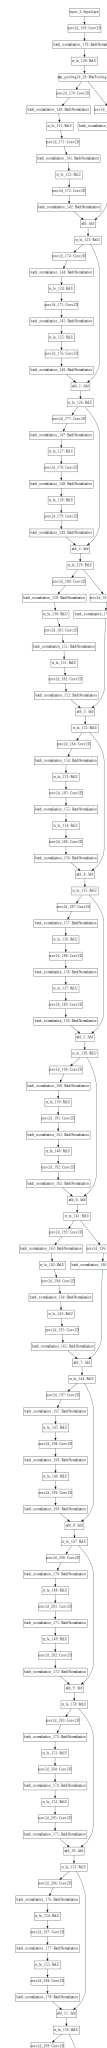

In [ ]:
SVG(model_to_dot(resNet_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % resNet_model.inputs)
print('Outputs: %s' % resNet_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'input_2')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_24')>]


####**Compile & Apply Model**

In [ ]:
resNet_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
import time
Re_t0 = time.time()
Re_history = resNet_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))
Re_t1 = time.time()
Re_time_linear_train = Re_t1-Re_t0

Epoch 1/20
50/50 [==============================] - 3s 62ms/step - loss: 2.7249 - accuracy: 0.5994 - val_loss: 1.0142 - val_accuracy: 0.5050
Epoch 2/20
50/50 [==============================] - 2s 43ms/step - loss: 1.4642 - accuracy: 0.6819 - val_loss: 1.0088 - val_accuracy: 0.5050
Epoch 3/20
50/50 [==============================] - 2s 43ms/step - loss: 0.7981 - accuracy: 0.7756 - val_loss: 0.8486 - val_accuracy: 0.5050
Epoch 4/20
50/50 [==============================] - 2s 43ms/step - loss: 0.5272 - accuracy: 0.8406 - val_loss: 1.4265 - val_accuracy: 0.5050
Epoch 5/20
50/50 [==============================] - 2s 44ms/step - loss: 0.4088 - accuracy: 0.8594 - val_loss: 1.1871 - val_accuracy: 0.5075
Epoch 6/20
50/50 [==============================] - 2s 43ms/step - loss: 0.3198 - accuracy: 0.8931 - val_loss: 2.1978 - val_accuracy: 0.5050
Epoch 7/20
50/50 [==============================] - 2s 43ms/step - loss: 0.1783 - accuracy: 0.9381 - val_loss: 1.0235 - val_accuracy: 0.6025
Epoch 8/20
50

#### **Performance Visualization**

In [ ]:
# Validation Accuracy
resNet_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 15ms/step - loss: 0.9966 - accuracy: 0.7375


[0.9965918064117432, 0.737500011920929]

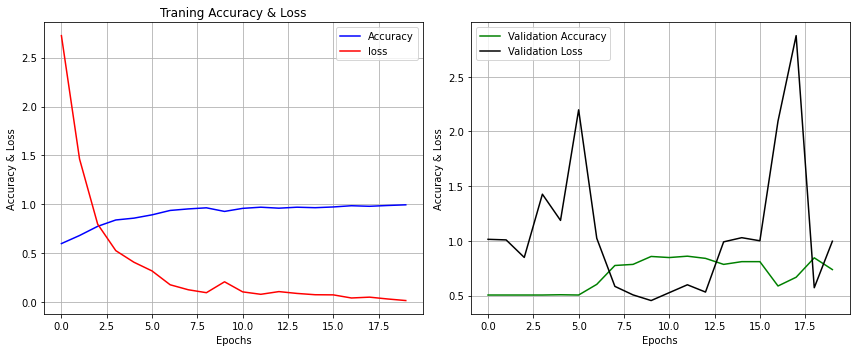

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Re_history.history['accuracy'], color='blue', label='train')
plt.plot(Re_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Re_history.history['val_accuracy'], color='green', label='test')
plt.plot(Re_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('Re_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

Re_model_pt1 = time.time()
Re_model_y_pred = resNet_model.predict(x_test)
Re_model_pt2 = time.time()
Re_model_time_linear_predict = Re_model_pt2-Re_model_pt1
Re_y_pred_classes = [np.argmax(element) for element in Re_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (Re_time_linear_train, cnn_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, Re_y_pred_classes))

Training time: 44.167351s; Prediction time: 0.052253s
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.55      0.67       198
           1       0.68      0.93      0.78       202

    accuracy                           0.74       400
   macro avg       0.78      0.74      0.73       400
weighted avg       0.78      0.74      0.73       400



In [ ]:
Renet_model_accuracy_score=round(accuracy_score(y_test_rounded, Re_y_pred_classes)*100,1)
Renet_model_f1_score = round(f1_score(y_test_rounded, Re_y_pred_classes, average='weighted')*100,1)
Renet_model_average_precision_score =round(average_precision_score(y_test_rounded, Re_y_pred_classes)*100,1)
Renet_model_recall_score = round(recall_score(y_test_rounded, Re_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', Renet_model_accuracy_score)
print('Model F1 Score:        ', Renet_model_f1_score)
print('Model Precision Score: ', Renet_model_average_precision_score)
print('Model Recall Score:    ', Renet_model_recall_score)

Model Accuracy Score:   73.8
Model F1 Score:         72.7
Model Precision Score:  66.2
Model Recall Score:     73.6


### **ResNeXT Model**

In [ ]:
def resnext(input_shape, n_classes):
  
  def conv_bn_rl(x, f, k=1, s=1, g=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, groups=g)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
   
  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, 1, 32)
    x = Conv2D(2*f, 1)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, tensor])
    output = ReLU()(x)
    return output
  
  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(2*f, 1)(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(2*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output
  
  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x
    
  input = Input(input_shape)
  
  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = resnet_block(x, 128, 3, 1)
  x = resnet_block(x, 256, 4)
  x = resnet_block(x, 512, 6)
  x = resnet_block(x, 1024, 3)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
resNeXt_model = resnext(x_train[0].shape, classes)

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('rexnet_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        resNeXt_model.summary()

resNeXt_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_222 (Conv2D)             (None, 25, 25, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_192 (BatchN (None, 25, 25, 64)   256         conv2d_222[0][0]                 
__________________________________________________________________________________________________
re_lu_169 (ReLU)                (None, 25, 25, 64)   0           batch_normalization_192[0][0]    
____________________________________________________________________________________________

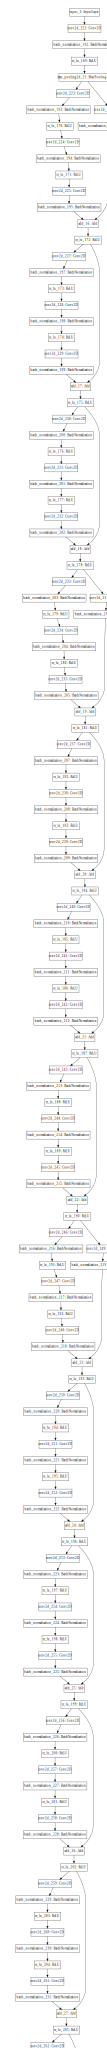

In [ ]:
SVG(model_to_dot(resNeXt_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % resNeXt_model.inputs)
print('Outputs: %s' % resNeXt_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'input_3')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_25')>]


####**Compile & Apply Model**

In [ ]:
resNeXt_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
import time
Rx_t0 = time.time()
Rx_history = resNeXt_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))
Rx_t1 = time.time()
Rx_time_linear_train = Rx_t1-Rx_t0

Epoch 1/20
50/50 [==============================] - 4s 75ms/step - loss: 1.5823 - accuracy: 0.6419 - val_loss: 0.9418 - val_accuracy: 0.5050
Epoch 2/20
50/50 [==============================] - 4s 75ms/step - loss: 0.7795 - accuracy: 0.7725 - val_loss: 1.0317 - val_accuracy: 0.5050
Epoch 3/20
50/50 [==============================] - 4s 75ms/step - loss: 0.5662 - accuracy: 0.8125 - val_loss: 0.7320 - val_accuracy: 0.4950
Epoch 4/20
50/50 [==============================] - 4s 75ms/step - loss: 0.4941 - accuracy: 0.8344 - val_loss: 1.1169 - val_accuracy: 0.5050
Epoch 5/20
50/50 [==============================] - 4s 75ms/step - loss: 0.1523 - accuracy: 0.9381 - val_loss: 1.3469 - val_accuracy: 0.5050
Epoch 6/20
50/50 [==============================] - 4s 75ms/step - loss: 0.2299 - accuracy: 0.9413 - val_loss: 1.0427 - val_accuracy: 0.5175
Epoch 7/20
50/50 [==============================] - 4s 75ms/step - loss: 0.1813 - accuracy: 0.9287 - val_loss: 1.8011 - val_accuracy: 0.5075
Epoch 8/20
50

#### **Performance Visualization**

In [ ]:
# Validation Accuracy
resNeXt_model.evaluate(x_test, y_test)

216/216 [==============================] - 3s 14ms/step - loss: 8.1373 - accuracy: 0.4786


[8.137301445007324, 0.47863247990608215]

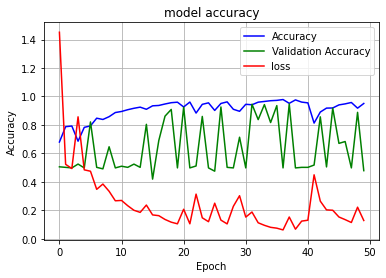

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Rx_history.history['accuracy'], color='blue', label='train')
plt.plot(Rx_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Rx_history.history['val_accuracy'], color='green', label='test')
plt.plot(Rx_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('Rx_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

Rx_model_pt1 = time.time()
Rx_model_y_pred = resNeXt_model.predict(x_test)
Rx_model_pt2 = time.time()
Rx_model_time_linear_predict = Rx_model_pt2 - Rx_model_pt1
Rx_y_pred_classes = [np.argmax(element) for element in Rx_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (Rx_time_linear_train, Rx_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, Rx_y_pred_classes))

Training time: 75.016358s; Prediction time: 1.001809s
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.15      0.26       198
           1       0.55      1.00      0.71       202

    accuracy                           0.58       400
   macro avg       0.77      0.58      0.48       400
weighted avg       0.77      0.58      0.49       400



In [ ]:
Rxnet_model_accuracy_score=round(accuracy_score(y_test_rounded, Rx_y_pred_classes)*100,1)
Rxnet_model_f1_score = round(f1_score(y_test_rounded, Rx_y_pred_classes, average='weighted')*100,1)
Rxnet_model_average_precision_score =round(average_precision_score(y_test_rounded, Rx_y_pred_classes)*100,1)
Rxnet_model_recall_score = round(recall_score(y_test_rounded, Rx_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', Rxnet_model_accuracy_score)
print('Model F1 Score:        ', Rxnet_model_f1_score)
print('Model Precision Score: ', Rxnet_model_average_precision_score)
print('Model Recall Score:    ', Rxnet_model_recall_score)

Model Accuracy Score:   58.0
Model F1 Score:         48.7
Model Precision Score:  54.6
Model Recall Score:     57.6


### **SE- ResNet**

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001
        
    block_name = str(stage) + "_" + str(block)
    conv_name_base = "conv" + block_name
    relu_name_base = "relu" + block_name

    x = Conv2D(filters1, (1, 1), use_bias=False, name=conv_name_base + '_x1')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x1_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x1')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=False, name=conv_name_base + '_x2')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x2_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x2')(x)

    x = Conv2D(filters3, (1, 1), use_bias=False, name=conv_name_base + '_x3')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x3_bn')(x)

    se = GlobalAveragePooling2D(name='pool' + block_name + '_gap')(x)
    se = Dense(filters3 // 16, activation='relu', name = 'fc' + block_name + '_sqz')(se)
    se = Dense(filters3, activation='sigmoid', name = 'fc' + block_name + '_exc')(se)
    se = Reshape([1, 1, filters3])(se)
    x = Multiply(name='scale' + block_name)([x, se])

    x = layers.add([x, input_tensor], name='block_' + block_name)
    x = Activation('relu', name=relu_name_base)(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001
    
    block_name = str(stage) + "_" + str(block)
    conv_name_base = "conv" + block_name
    relu_name_base = "relu" + block_name

    x = Conv2D(filters1, (1, 1), use_bias=False, name=conv_name_base + '_x1')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x1_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x1')(x)

    x = Conv2D(filters2, kernel_size, strides=strides, padding='same', use_bias=False, name=conv_name_base + '_x2')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x2_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x2')(x)

    x = Conv2D(filters3, (1, 1), use_bias=False, name=conv_name_base + '_x3')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x3_bn')(x)
    
    se = GlobalAveragePooling2D(name='pool' + block_name + '_gap')(x)
    se = Dense(filters3 // 16, activation='relu', name = 'fc' + block_name + '_sqz')(se)
    se = Dense(filters3, activation='sigmoid', name = 'fc' + block_name + '_exc')(se)
    se = Reshape([1, 1, filters3])(se)
    x = Multiply(name='scale' + block_name)([x, se])
    
    shortcut = Conv2D(filters3, (1, 1), strides=strides, use_bias=False, name=conv_name_base + '_prj')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_prj_bn')(shortcut)

    x = layers.add([x, shortcut], name='block_' + block_name)
    x = Activation('relu', name=relu_name_base)(x)
    return x


def SEResNet50(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=2):

    # Determine proper input shape
    input_shape = x_train[0].shape
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False, name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name='conv1_bn')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc6')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='se-resnet50')
    return model  

In [ ]:
seResNet_model = SEResNet50(x_train[0].shape, classes)

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('SEnet_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        seResNet_model.summary()


seResNet_model.summary()

Model: "se-resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 25, 25, 64)   9408        input_5[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
relu1 (Activation)              (None, 25, 25, 64)   0           conv1_bn[0][0]                   
________________________________________________________________________________________

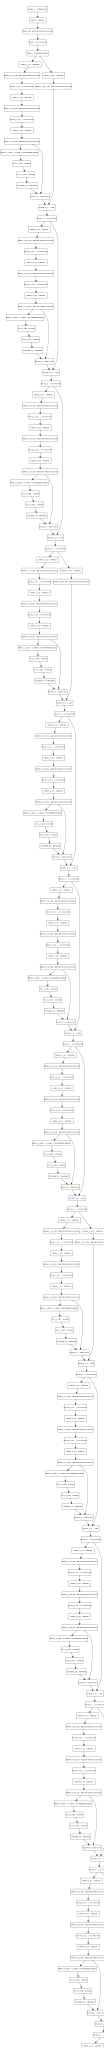

In [ ]:
SVG(model_to_dot(seResNet_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % seResNet_model.inputs)
print('Outputs: %s' % seResNet_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'input_5')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'fc6')>]


####**Compile & Apply Model**

In [ ]:
seResNet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
import time
SE_t0 = time.time()
SE_history = seResNet_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))
SE_t1 = time.time()
SE_time_linear_train = SE_t1-SE_t0

Epoch 1/20
50/50 [==============================] - 4s 71ms/step - loss: 2.5889 - accuracy: 0.5688 - val_loss: 0.7309 - val_accuracy: 0.5050
Epoch 2/20
50/50 [==============================] - 2s 47ms/step - loss: 0.9390 - accuracy: 0.6450 - val_loss: 1.1086 - val_accuracy: 0.5050
Epoch 3/20
50/50 [==============================] - 2s 47ms/step - loss: 1.0141 - accuracy: 0.6344 - val_loss: 0.8895 - val_accuracy: 0.5050
Epoch 4/20
50/50 [==============================] - 2s 47ms/step - loss: 0.8493 - accuracy: 0.6906 - val_loss: 0.8606 - val_accuracy: 0.5050
Epoch 5/20
50/50 [==============================] - 2s 47ms/step - loss: 0.7417 - accuracy: 0.7588 - val_loss: 18.1549 - val_accuracy: 0.5350
Epoch 6/20
50/50 [==============================] - 2s 47ms/step - loss: 0.5557 - accuracy: 0.7781 - val_loss: 1.6138 - val_accuracy: 0.4575
Epoch 7/20
50/50 [==============================] - 2s 47ms/step - loss: 0.5521 - accuracy: 0.8019 - val_loss: 662.7146 - val_accuracy: 0.5200
Epoch 8/20

#### **Performance Visualization**

In [ ]:
# Validation Accuracy
seResNet_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 15ms/step - loss: 7.2089 - accuracy: 0.5050


[7.208920478820801, 0.5049999952316284]

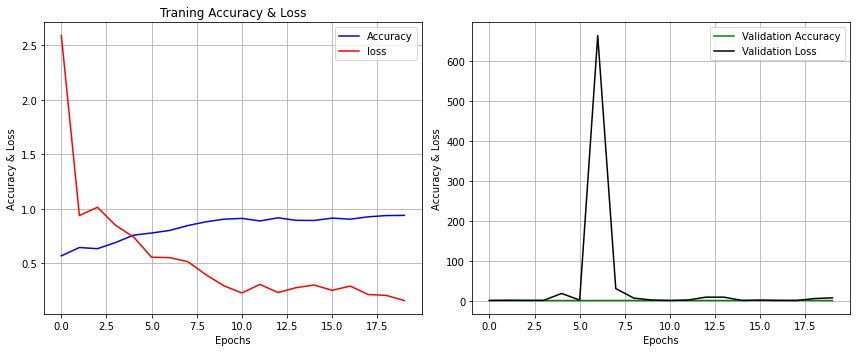

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(SE_history.history['accuracy'], color='blue', label='train')
plt.plot(SE_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(SE_history.history['val_accuracy'], color='green', label='test')
plt.plot(SE_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('SE_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

SE_model_pt1 = time.time()
SE_model_y_pred = seResNet_model.predict(x_test)
SE_model_pt2 = time.time()
SE_model_time_linear_predict = SE_model_pt2-SE_model_pt1
SE_y_pred_classes = [np.argmax(element) for element in SE_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (SE_time_linear_train, SE_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, SE_y_pred_classes))

Training time: 48.320654s; Prediction time: 0.188571s
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.51      1.00      0.67       202

    accuracy                           0.51       400
   macro avg       0.25      0.50      0.34       400
weighted avg       0.26      0.51      0.34       400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
SEnet_model_accuracy_score=round(accuracy_score(y_test_rounded, SE_y_pred_classes)*100,1)
SEnet_model_f1_score = round(f1_score(y_test_rounded, SE_y_pred_classes, average='weighted')*100,1)
SEnet_model_average_precision_score =round(average_precision_score(y_test_rounded, SE_y_pred_classes)*100,1)
SEnet_model_recall_score = round(recall_score(y_test_rounded, SE_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', SEnet_model_accuracy_score)
print('Model F1 Score:        ', SEnet_model_f1_score)
print('Model Precision Score: ', SEnet_model_average_precision_score)
print('Model Recall Score:    ', SEnet_model_recall_score)

Model Accuracy Score:   50.5
Model F1 Score:         33.9
Model Precision Score:  50.5
Model Recall Score:     50.0


### **EfficientNet Model**

In [ ]:
#from tensorflow.keras.applications import MobileNetV2
import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model 

In [ ]:
efficientNet_model = EfficientNetB0(weights=None, input_shape=x_train[0].shape, pooling=None, classes=classes, classifier_activation='softmax')

#### **Print and plot the model**

In [ ]:
from contextlib import redirect_stdout

with open('effnet_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        efficientNet_model.summary()


efficientNet_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 50, 50, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 50, 50, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 51, 51, 3)    0           normalization[0][0]              
_____________________________________________________________________________________

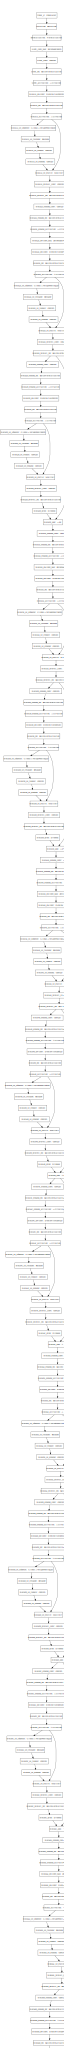

In [ ]:
SVG(model_to_dot(efficientNet_model).create(prog='dot', format='svg'))

In [ ]:
# summarize input and output shape
print('Inputs: %s' % efficientNet_model.inputs)
print('Outputs: %s' % efficientNet_model.outputs)

Inputs: [<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'input_6')>]
Outputs: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'predictions')>]


####**Compile & Apply Model**

In [ ]:
efficientNet_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
import time
Eff_t0 = time.time()
Eff_history = efficientNet_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))
Eff_t1 = time.time()
Eff_time_linear_train = Eff_t1 - Eff_t0

Epoch 1/20
50/50 [==============================] - 9s 58ms/step - loss: 4.2766 - accuracy: 0.4968 - val_loss: 1.0059 - val_accuracy: 0.4950
Epoch 2/20
50/50 [==============================] - 2s 31ms/step - loss: 1.5187 - accuracy: 0.5459 - val_loss: 0.6952 - val_accuracy: 0.4950
Epoch 3/20
50/50 [==============================] - 2s 31ms/step - loss: 1.2613 - accuracy: 0.5858 - val_loss: 1.0729 - val_accuracy: 0.5050
Epoch 4/20
50/50 [==============================] - 2s 31ms/step - loss: 1.1843 - accuracy: 0.6083 - val_loss: 0.7383 - val_accuracy: 0.4950
Epoch 5/20
50/50 [==============================] - 2s 31ms/step - loss: 0.9568 - accuracy: 0.6430 - val_loss: 0.7479 - val_accuracy: 0.5050
Epoch 6/20
50/50 [==============================] - 2s 31ms/step - loss: 0.8606 - accuracy: 0.6860 - val_loss: 0.7949 - val_accuracy: 0.5050
Epoch 7/20
50/50 [==============================] - 2s 32ms/step - loss: 0.9036 - accuracy: 0.7056 - val_loss: 0.7089 - val_accuracy: 0.4950
Epoch 8/20
50

#### **Performance Visualization**

In [ ]:
# Validation Score
efficientNet_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 11ms/step - loss: 0.9852 - accuracy: 0.6650


[0.98516845703125, 0.6650000214576721]

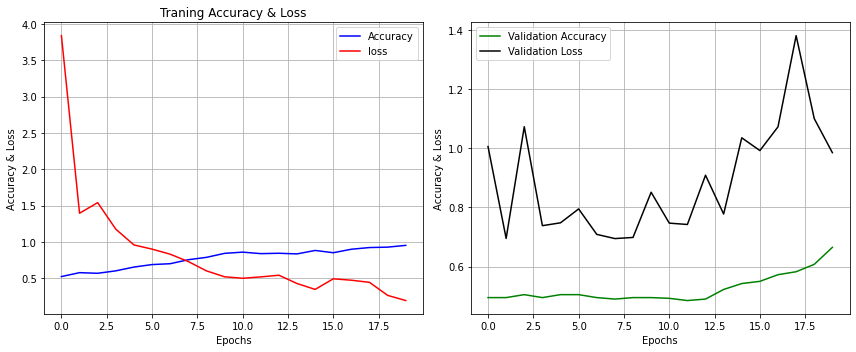

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Eff_history.history['accuracy'], color='blue', label='train')
plt.plot(Eff_history.history['loss'], color='red', label='test')
plt.title("Traning Accuracy & Loss")
plt.legend(["Accuracy","loss"])

plt.subplot(1, 2, 2)
plt.grid(True)
plt.ylabel("Accuracy & Loss")
plt.xlabel("Epochs")
plt.plot(Eff_history.history['val_accuracy'], color='green', label='test')
plt.plot(Eff_history.history['val_loss'], color='black', label='test')
plt.legend(["Validation Accuracy","Validation Loss"])

plt.tight_layout()
plt.savefig('Eff_model_acc_plot.png')
plt.show()

#### **Training/ Pridction Time, Accuracy, Precision, Recall & F1 Score**

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, f1_score, average_precision_score, recall_score
import numpy as np

Eff_model_pt1 = time.time()
Eff_model_y_pred = efficientNet_model.predict(x_test)
Eff_model_pt2 = time.time()
Eff_model_time_linear_predict = Eff_model_pt2-Eff_model_pt1
Eff_y_pred_classes = [np.argmax(element) for element in Eff_model_y_pred]
print("Training time: %fs; Prediction time: %fs" % (Eff_time_linear_train, Eff_model_time_linear_predict))
y_test_rounded=np.argmax(y_test, axis=1)
print("Classification Report: \n", classification_report(y_test_rounded, Eff_y_pred_classes))

Training time: 39.792492s; Prediction time: 0.139380s
Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.66      0.66       198
           1       0.67      0.67      0.67       202

    accuracy                           0.67       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.67      0.66       400



In [ ]:
Effnet_model_accuracy_score=round(accuracy_score(y_test_rounded, Eff_y_pred_classes)*100,1)
Effnet_model_f1_score = round(f1_score(y_test_rounded, Eff_y_pred_classes, average='weighted')*100,1)
Effnet_model_average_precision_score =round(average_precision_score(y_test_rounded, Eff_y_pred_classes)*100,1)
Effnet_model_recall_score = round(recall_score(y_test_rounded, Eff_y_pred_classes, average='macro')*100,1)
print('Model Accuracy Score:  ', Effnet_model_accuracy_score)
print('Model F1 Score:        ', Effnet_model_f1_score)
print('Model Precision Score: ', Effnet_model_average_precision_score)
print('Model Recall Score:    ', Effnet_model_recall_score)

Model Accuracy Score:   66.5
Model F1 Score:         66.5
Model Precision Score:  61.4
Model Recall Score:     66.5


## **Comparison of Models**

In [ ]:
# Values from the models
classification_models = ['Proposed CNN','Proposed CNN Augmented','ANN', 'CNN', 'AlexNet', 'LeNet5', 'DenseNet', 'ResNet','ResNeXt', 'SE-ResNet','EfficientNet']  
training_time = [model_time_linear_train, model_aug_time_linear_train, ann_model_time_linear_train, cnn_model_time_linear_train, alexnet_model_time_linear_train, Le_time_linear_train, De_time_linear_train, Re_time_linear_train, Rx_time_linear_train, SE_time_linear_train, Eff_time_linear_train ]
val_time = [model_time_linear_predict,model_aug_time_linear_predict,ann_model_time_linear_predict, cnn_model_time_linear_predict, alexnet_model_time_linear_predict, Le_model_time_linear_predict, De_model_time_linear_predict, Re_model_time_linear_predict, Rx_model_time_linear_predict,SE_model_time_linear_predict , Eff_model_time_linear_predict  ]

acc = [model_accuracy_score, model_aug_accuracy_score, ann_model_accuracy_score, cnn_model_accuracy_score, alexnet_model_accuracy_score, lenet_model_accuracy_score, Denet_model_accuracy_score, Renet_model_accuracy_score, Rxnet_model_accuracy_score,SEnet_model_accuracy_score, Effnet_model_accuracy_score]
f1 = [model_f1_score, model_aug_f1_score, ann_model_f1_score, cnn_model_f1_score, alexnet_model_f1_score, lenet_model_f1_score, Denet_model_f1_score, Renet_model_f1_score, Rxnet_model_f1_score, SEnet_model_f1_score, Effnet_model_f1_score]

precision = [model_average_precision_score, model_aug_average_precision_score, ann_model_average_precision_score, cnn_model_average_precision_score, alexnet_model_average_precision_score, lenet_model_average_precision_score, Denet_model_average_precision_score, Renet_model_average_precision_score, Rxnet_model_average_precision_score, SEnet_model_average_precision_score, Effnet_model_average_precision_score]
recall = [model_recall_score, model_aug_recall_score, ann_model_recall_score, cnn_model_recall_score, alexnet_model_recall_score, lenet_model_recall_score, Denet_model_recall_score, Renet_model_recall_score, Rxnet_model_recall_score, SEnet_model_recall_score, Effnet_model_recall_score]

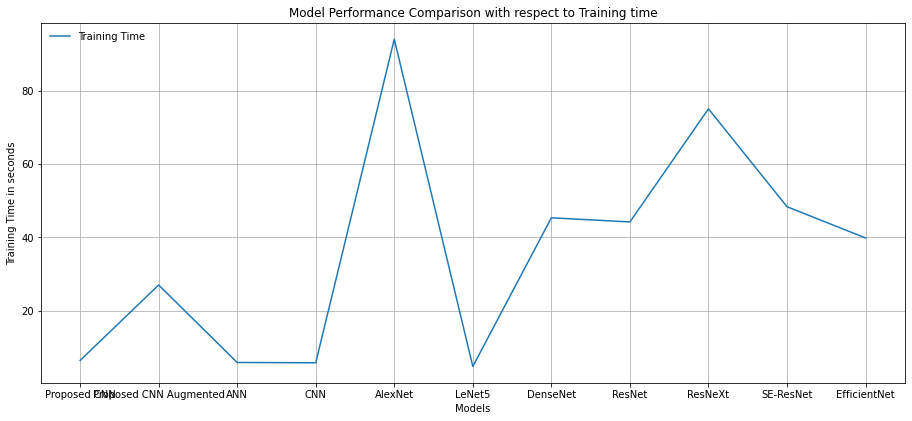

In [ ]:
fig = plt.figure(figsize = (12,5))
ax=fig.add_axes([0,0,1,1])
ax.set_title('Model Performance Comparison with respect to Training time')
ax.set_xlabel('Models')
ax.set_ylabel('Training Time in seconds')
#ax.set_ylim(40,100)
ax.plot(classification_models,training_time, label="Training Time")
ax.legend(loc='upper left', frameon=False)
plt.grid(True)
plt.savefig('trgtime_plot.png')
plt.show()

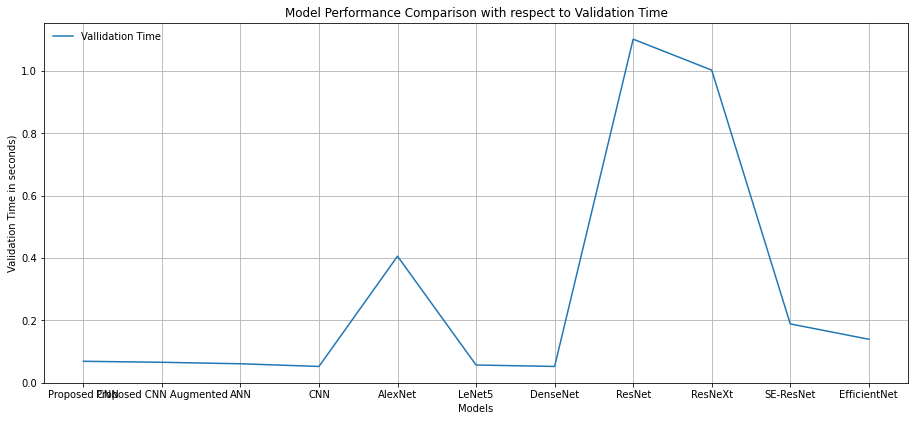

In [ ]:
fig = plt.figure(figsize = (12,5))
ax=fig.add_axes([0,0,1,1])
ax.set_title('Model Performance Comparison with respect to Validation Time')
ax.set_xlabel('Models')
ax.set_ylabel('Validation Time in seconds)')
#ax.set_ylim(40,100)
ax.plot(classification_models,val_time, label="Vallidation Time")
ax.legend(loc='upper left', frameon=False)
plt.grid(True)
plt.savefig('valtime_plot.png')
plt.show()

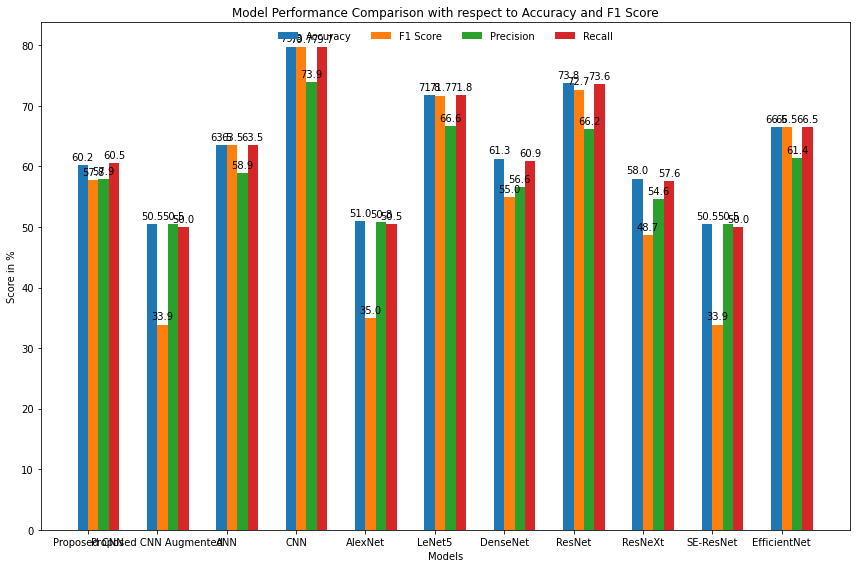

In [ ]:
x = np.arange(len(classification_models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1, width, label='F1 Score')
rects3 = ax.bar(x + width*1.5, precision, width, label='Precision')
rects4 = ax.bar(x + width*2.5, recall, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score in %')
ax.set_title('Model Performance Comparison with respect to Accuracy and F1 Score')
ax.set_xlabel('Models')
ax.set_xticks(x)
ax.set_xticklabels(classification_models)
ax.legend(loc='upper center', frameon=False, ncol = 4)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.savefig('comp_model_plot.png')
plt.show()

#### **Let's make some predictions**
Above graph shows that CNN, SE ResNet and EfficientNet are performing well. Let make some perdiction on these models.
Following is the analysis of first 100 images 

In [ ]:
# Actual test labels
y_test[:100]   

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [ ]:
# Prediction on convolutional Neural Networks Model
y_pred_classes[:100]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
# Prediction on SE-Residual Neural Networks Model
SE_y_pred_classes[:100]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
# Prediction on EfficientNet Neural Networks Model
Eff_y_pred_classes[:100]

[1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1]

#Classifying Cell Images in Testing Set

In [ ]:
predictions = clf.predict(pca_X_test)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
TP, FP, FN, TN = confusion_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test, predictions)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test, predictions)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test, predictions)))
print('Specificity: {0:.3f}'.format(specificity))

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
TP, FP, FN, TN = confusion_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test, predictions)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test, predictions)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test, predictions)))
print('Specificity: {0:.3f}'.format(specificity))

In [ ]:
import pickle

with open('outfile', 'wb') as fp:
    pickle.dump(itemlist, fp)

In [ ]:
with open ('outfile', 'rb') as fp:
    itemlist = pickle.load(fp)

In [ ]:
images , labels = load_rgb_data(faces_dataset_path,32,shuffle=True)

## **`Data Visualization & Preprocessing`**

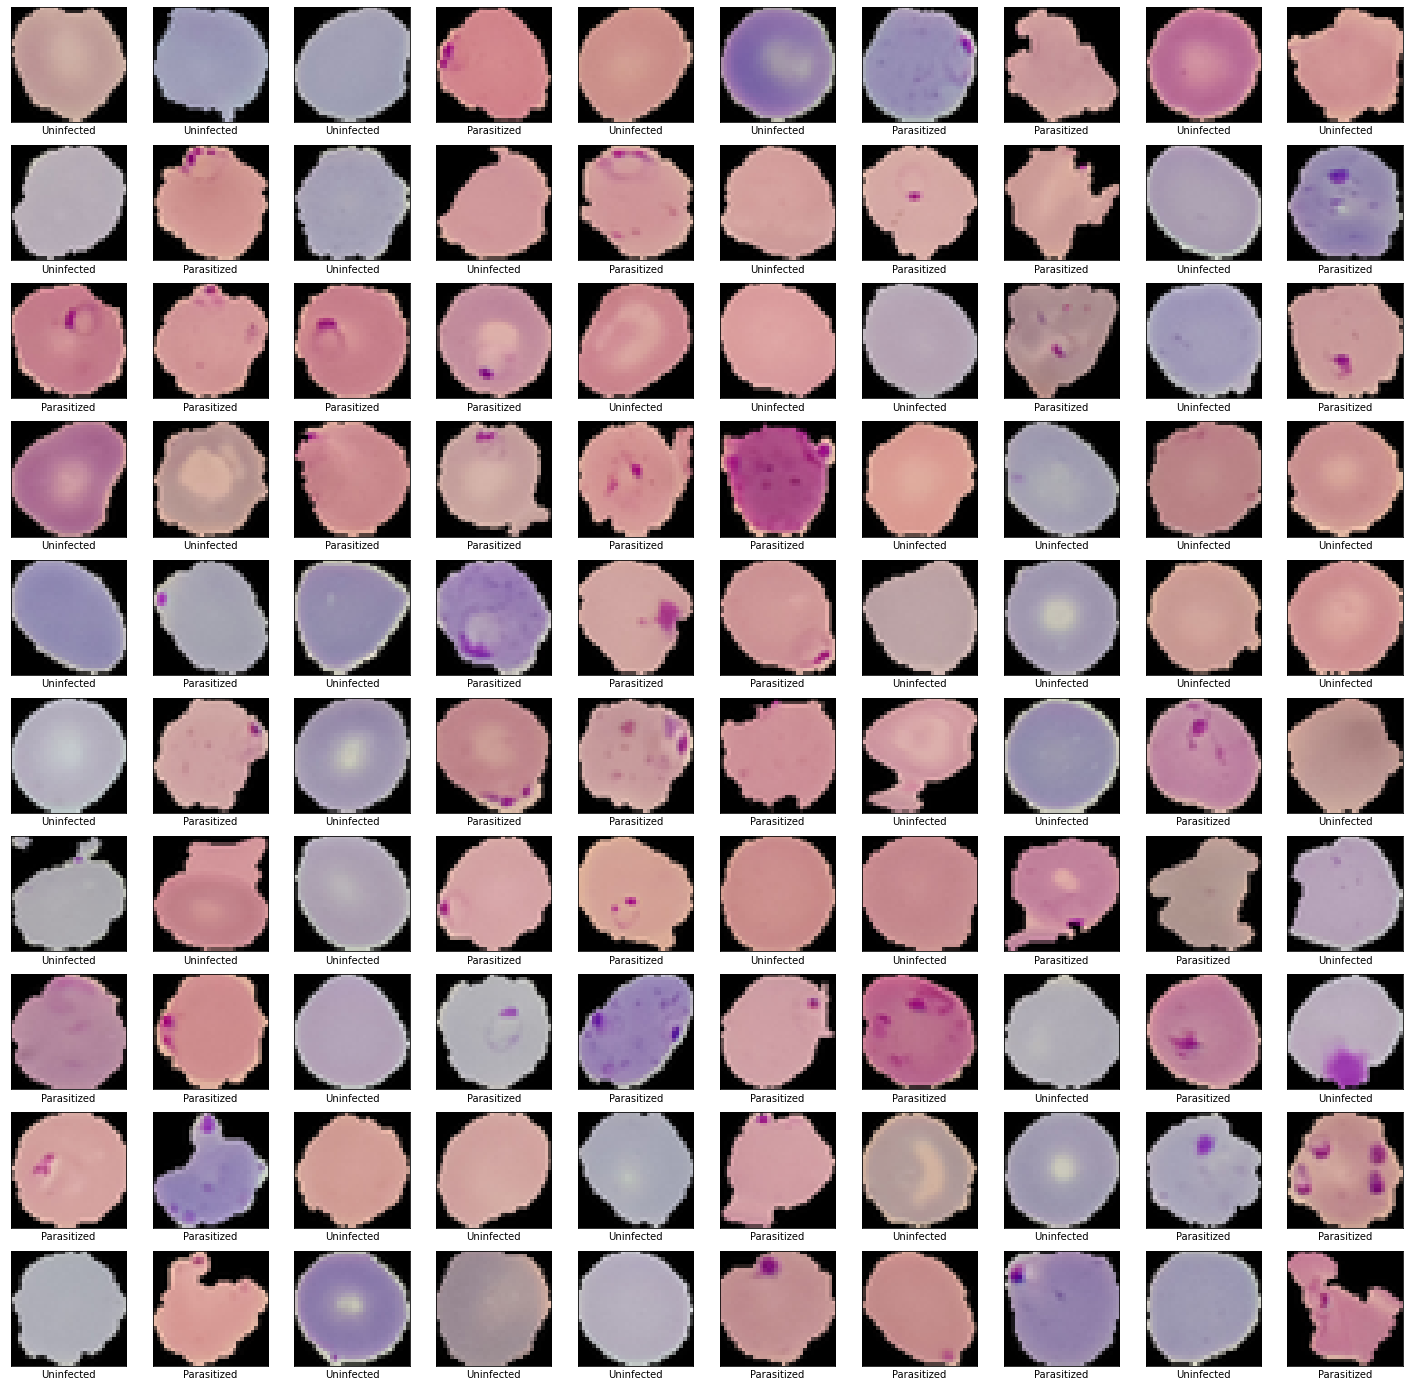

In [ ]:
plot_sample_from_dataset(images , labels , rows = 10 , colums = 10 , width = 25 , height = 25)

In [ ]:
images.shape

(27610, 32, 32, 3)

In [ ]:
labels.shape

(27610,)

In [ ]:
labels[:10]

array(['Uninfected', 'Uninfected', 'Uninfected', 'Parasitized',
       'Uninfected', 'Uninfected', 'Parasitized', 'Parasitized',
       'Uninfected', 'Uninfected'], dtype='<U11')

## **Preprocessing of Data**

### **Encode Labels**

In [ ]:
from sklearn import preprocessing
label_names = ['Uninfected' , 'Parasitized']
classes = len(label_names)
encoder = preprocessing.LabelEncoder()
label_codes = encoder.fit(label_names)
encoded_labels = encoder.transform(labels)

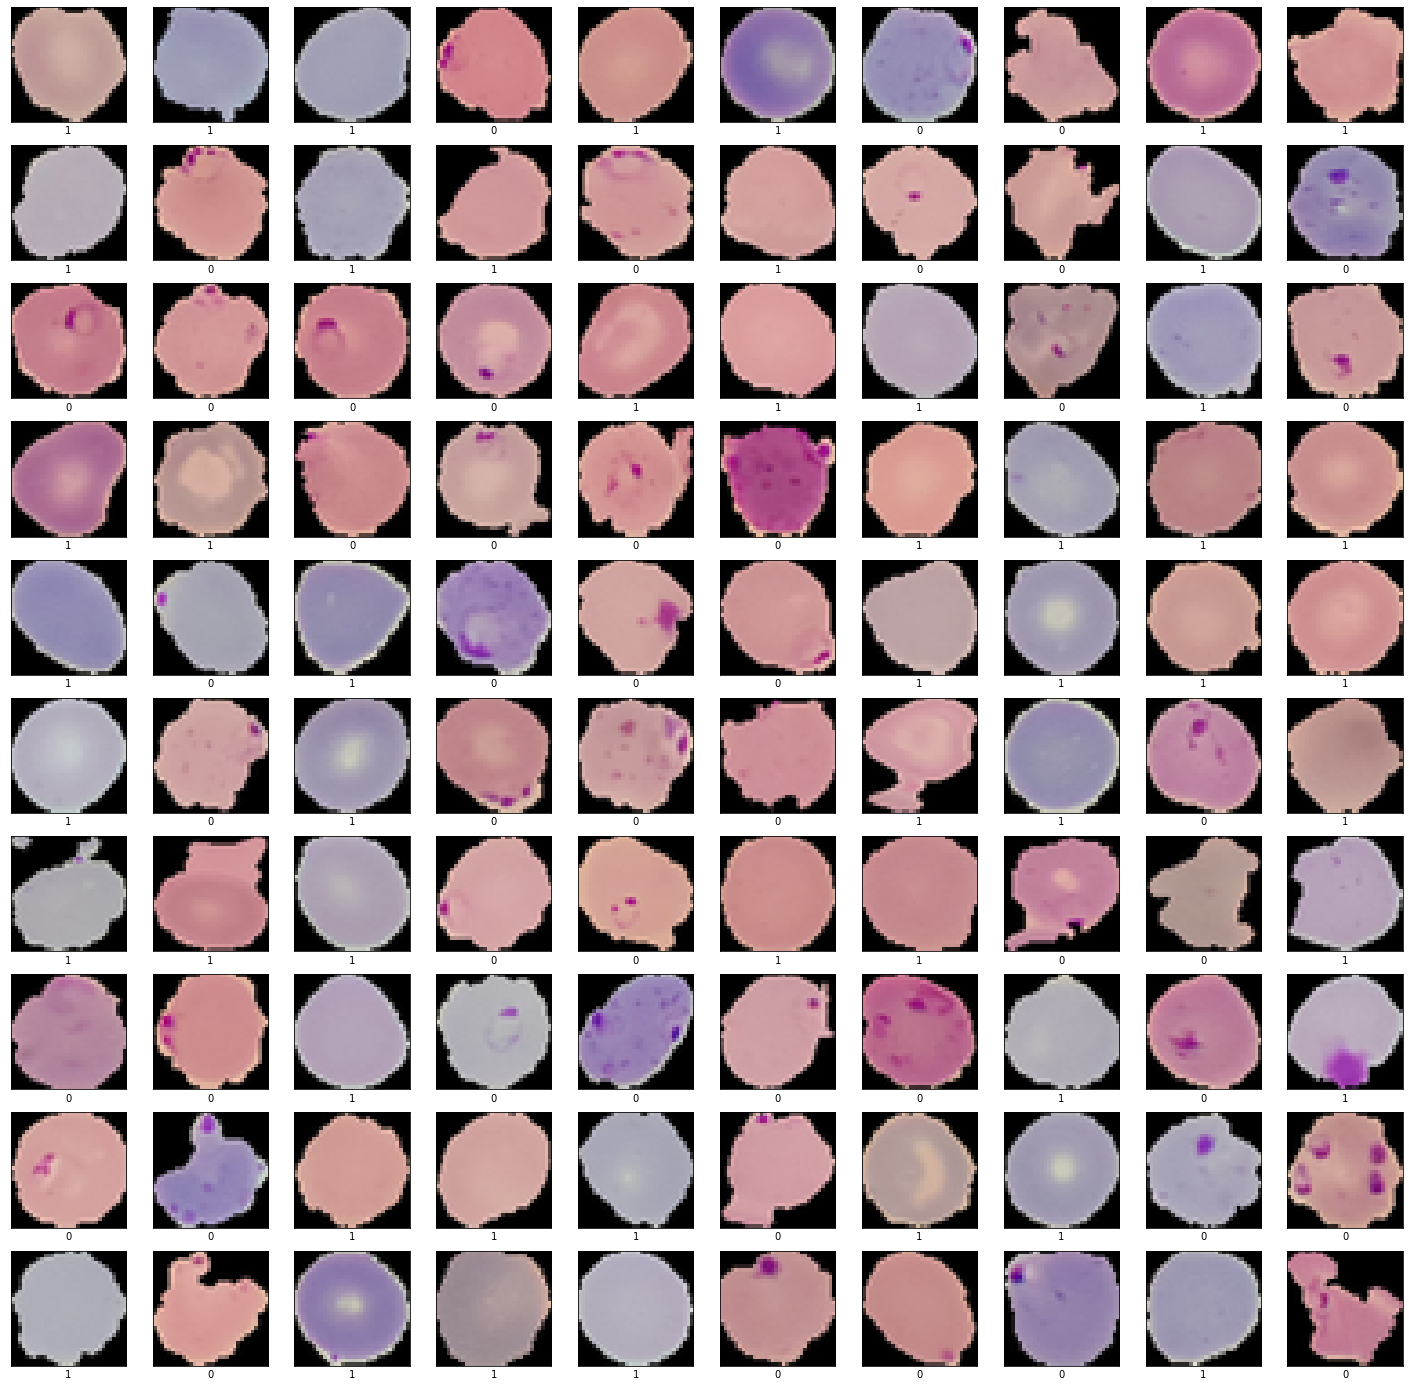

In [ ]:
plot_sample_from_dataset(images , encoded_labels , rows = 10 , colums = 10 , width = 25 , height = 25)

### **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=.25)

In [ ]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((20707, 32, 32, 3), (6903, 32, 32, 3), (20707,), (6903,))

### **Scale/ Normalize images**

In [ ]:
x_train = x_train/255.0
x_test=x_test/255.0

### **One hot encoding**

In [ ]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, classes)
y_test_encoded = to_categorical(y_test, classes)

In [ ]:
y_train_encoded[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
img_read = plt.imread(parasitized_images_path + "/" + img)
img_resize = cv2.resize(img_read, (50, 50))

from PIL import Image
import numpy as np
import os, os.path, time

def createFileList(my_dir, format='.png'):
  fileList = []
  print(my_dir)
  for root, dirs, files in os.walk(my_dir, topdown=False):
    for name in files:
      if name.endswith(format):
        fullName = os.path.join(root, name)
        fileList.append(fullName)
  return fileList

# Load the original image

myfileList = createFileList(parasitized_images_path)
#fileFormat='.png'
for file in myfileList:
  print(file)
  img_file = Image.open(file)
# get original image parameters...
  width, height = img_file.size
  format = img_file.format
  mode = img_file.mode
  # Make image Greyscale
  img_grey = img_file.convert('L')
  # Save Greyscale values
  value = np.asarray(img_grey.getdata(),dtype=np.int).reshape((img_grey.size[1],img_grey.size[0]))
  value=value.flatten()
  print(value)
  with open("/content/drive/MyDrive/malaria_cell_csv/parasitized_img_pixels.csv", 'a') as f:
    writer=csv.writer(f)
    writer.writerow(value)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/malaria_cell_images/Parasitized/C128P89ThinF_IMG_20151004_131753_cell_132.png
[0 0 0 ... 0 0 0]
/content/drive/MyDrive/malaria_cell_images/Parasitized/C128P89ThinF_IMG_20151004_131632_cell_169.png
[0 0 0 ... 0 0 0]
/content/drive/MyDrive/malaria_cell_images/Parasitized/C128P89ThinF_IMG_20151004_131753_cell_125.png
[0 0 0 ... 0 0 0]
/content/drive/MyDrive/malaria_cell_images/Parasitized/C129P90ThinF_IMG_20151004_133244_cell_102.png
[0 0 0 ... 0 0 0]
/content/drive/MyDrive/malaria_cell_images/Parasitized/C128P89ThinF_IMG_20151004_131753_cell_127.png
[0 0 0 ... 0 0 0]
/content/drive/MyDrive/malaria_cell_images/Parasitized/C128P89ThinF_IMG_20151004_131632_cell_170.png
[0 0 0 ... 0 0 0]
/content/drive/MyDrive/malaria_cell_images/Parasitized/C129P90ThinF_IMG_20151004_133244_cell_116.png
[0 0 0 ... 0 0 0]
/content/drive/MyDrive/malaria_cell_images/Parasitized/C129P90ThinF_IMG_20151004_133244_cell_113.png
[0 0 0 ... 0 0 

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

kernels = ["rbf", "linear", "poly"]
C=[1.10,20]
avg_scores={}
for kval in kernels:
  for cval in C:
    cv_scores = cross_val_score(SVC(kernel=kval, C=cval, gamma='auto'),x_train, y_train_encoded)
    avg_scores[kval + '_' + str(cval)]=np.average(cv_scores)
avg_scores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with dim 4. Estimator expected <= 2.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with dim 4. Estimator expected <= 2.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Found array with dim 4. Estimator expected <= 2.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit 

{'linear_1.1': nan,
 'linear_20': nan,
 'poly_1.1': nan,
 'poly_20': nan,
 'rbf_1.1': nan,
 'rbf_20': nan}

In [ ]:
#Import svm model
from sklearn import svm


#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(x_train, y_train_encoded)

#Predict the response for test dataset
#y_pred = clf.predict(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)

nsamples, nx, ny, nc = x_train.shape
d2_x_train = x_train.reshape((nsamples,nx*ny))

clf.fit(d2_x_train, y_train_encoded)

NameError: ignored

In [ ]:
x_train.shape

(78, 32, 32, 3)

In [ ]:
from PIL import Image
import numpy as np
import os, os.path, time

def createFileList(my_dir, format='.png'):
  fileList = []
  print(my_dir)
  for root, dirs, files in os.walk(my_dir, topdown=False):
    for name in files:
      if name.endswith(format):
        fullName = os.path.join(root, name)
        fileList.append(fullName)
  return fileList

# Load the original image

myfileList = createFileList(uninfected_images_path)
#fileFormat='.png'
for file in myfileList:
  print(file)
  img_file = Image.open(file)
# get original image parameters...
  width, height = img_file.size
  format = img_file.format
  mode = img_file.mode
  # Make image Greyscale
  img_grey = img_file.convert('L')
  # Save Greyscale values
  value = np.asarray(img_grey.getdata(),dtype=np.int).reshape((img_grey.size[1],img_grey.size[0]))
  value=value.flatten()
  print(value)
  with open("/content/drive/MyDrive/malaria_cell_csv/uninfected_img_pixels.csv", 'a') as f:
    writer=csv.writer(f)
    writer.writerow(value)